In [2]:
import sys
import os
from typing import List
sys.path.append("..")

In [3]:
from collections import defaultdict
import os
import gzip
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
from colour import Color

from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch
from diachr.diachromatic_interaction_set import DiachromaticInteractionSet
from diachr.diachromatic_interaction import DiachromaticInteraction

### Implement `CHCTadViz`

In [4]:
class CHCTadViz:
    """
    This class coorrdinates the visualization of TADs.
    """

    def __init__(self, i_file, t_file) -> None:
        if not isinstance(i_file, str) or not os.path.isfile(i_file):
            raise ValueError("Invalid file {}".format(i_file))
        
        self._figure_size = 10 # What does that mean?
        
        print('[INFO] Initializing DirectedTadVisualizer object ...')
        
        print('\t[INFO] Reading interactions and group them by chromosomes ...')
        self._d_inter_by_chrom_dict = dict()
        d_inter_set = DiachromaticInteractionSet(rpc_rule = 'ht')
        d_inter_set.parse_file(i_file = i_file, verbose = False)
        for d_inter in d_inter_set.interaction_list:
            if d_inter.chrA == d_inter.chrB:
                if d_inter.chrA not in self._d_inter_by_chrom_dict:
                    self._d_inter_by_chrom_dict[d_inter.chrA] = [d_inter]
                else:
                    self._d_inter_by_chrom_dict[d_inter.chrA].append(d_inter)                    
        #for key, d_inter_list in self._d_inter_by_chrom_dict.items():
            #print('\t' + key + ': ' + '{:,}'.format(len(d_inter_list)) + ' interactions')
        print('\t[INFO] ... done.')
        
        print('\t[INFO] Reading TAD regions and group them by chromosomes ...')
        self._tads_by_chrom_dict = dict()
        with open(t_file, 'rt') as fp:
            next(fp)
            for line in fp:
                c, s, e = line.rstrip().split('\t')
                
                if c not in self._tads_by_chrom_dict:
                    self._tads_by_chrom_dict[c] = [(int(s), int(e))]
                else:
                    self._tads_by_chrom_dict[c].append((int(s), int(e)))
        #for key, tad_list in self._tads_by_chrom_dict.items():
            #print('\t' + key + ': ' + '{:,}'.format(len(tad_list)) + ' TADs')
        print('\t[INFO] ... done.')
        print('[INFO] ... done.')
        

    def extract_interactions(self, chrom, begin, end):
        """
        Create reduced interaction list that only contains interactions within the region to be visualized.
        """
        
        # Check arguments
        if not isinstance(chrom, str):
            raise ValueError("chrom must be a string")
        if not isinstance(begin, int) or not isinstance(end, int):
            raise ValueError("begin and end must be integers")
        
        # If there are no interactions for this chromosome, return empty list
        if chrom not in self._d_inter_by_chrom_dict:
            return inter_list
            
        # Extract interactions
        inter_list = []
        for d_inter in self._d_inter_by_chrom_dict[chrom]:
            
            # Only keep interactions completely within the region we want to visualize
            if d_inter.chrA == chrom and begin < d_inter.fromA and d_inter.toB < end:
                inter_list.append(d_inter)
            
        print("[INFO] Extracted {} interactions in range {}:{}-{}".format(len(inter_list), chrom, begin, end))      
        return inter_list

    def pos_to_coordinate(self, pos):
        """
        Convert genomic position to plot coordinate.
        """
        return (pos - self._min) * self._factor
        
    def coordinate_to_pos(self, coordinate):
        """
        Convert plot coordinate to genomic position.
        """
        return coordinate/self._factor + self._min
    
    def tad_to_grey_triangle(self, start:int, end:int) -> PolygonPatch:
        begin = self.pos_to_coordinate(start) 
        end = self.pos_to_coordinate(end)
        TANGENT_45 = math.tan(math.pi / 4)
        # bc is the point where lines from b and c meet
        midpoint_x = begin + 0.5 * (end - begin)
        # bc is the length of the segment from b to bc_x
        bc = midpoint_x - begin
        # tan = opposite/adjacent
        # opposite = tan(45)*adjacent
        bc_y = TANGENT_45 * bc
        poly = Polygon([(begin, 0), (midpoint_x, bc), (end, 0)])
        color = 'gray'
        return PolygonPatch(polygon=poly, color=color, alpha=0.25)
    
    def black_triangle_left(self, start:int, end:int):
        begin = self.pos_to_coordinate(start) 
        end = self.pos_to_coordinate(end)
        midpoint_x = begin + 0.5 * (end - begin)
        bc = midpoint_x - begin
        poly = Polygon([(begin, 0), (begin, bc), (midpoint_x, bc)])
        color = 'black'
        return PolygonPatch(polygon=poly, color=color)
    
    def black_triangle_right(self, start:int, end:int):
        begin = self.pos_to_coordinate(start) 
        end = self.pos_to_coordinate(end)
        midpoint_x = begin + 0.5 * (end - begin)
        bc = midpoint_x - begin
        poly = Polygon([(midpoint_x, bc), (end, bc), (end, 0)])
        color = 'black'
        return PolygonPatch(polygon=poly, color=color)
    
    def interaction_to_polygon(self, d_inter, pp_color, pp_alpha):
        """
        Creates a PolygonPatch for a given interaction.
        """
        if not isinstance(d_inter, DiachromaticInteraction):
            raise ValueError("Not a DiachromaticInteraction")
        
        TANGENT_45 = math.tan(math.pi / 4)  # The lines go up at 45 degree angles
        # a,b,c,d are coordinates of the two digests on the X axis
        a = self.pos_to_coordinate(d_inter.fromA)
        b = self.pos_to_coordinate(d_inter.toA)
        c = self.pos_to_coordinate(d_inter.fromB)
        d = self.pos_to_coordinate(d_inter.toB)
        # bc is the point where lines from b and c meet
        bc_x = b + 0.5 * (c - b)
        # bc is the length of the segment from b to bc_x
        bc = bc_x - b
        # tan = opposite/adjacent
        # opposite = tan(45)*adjacent
        bc_y = TANGENT_45 * bc
        # ad is the point where lines from a and d meet
        ad_x = a + 0.5 * (d - a)
        ad = ad_x - a
        ad_y = TANGENT_45 * ad
        # ac is the point where lines from a and c meet
        ac_x = a + 0.5 * (c - a)
        ac = ac_x - a
        ac_y = TANGENT_45 * ac
        # bd is the point where lines from b and d meet
        bd_x = b + 0.5 * (d - b)
        bd = bd_x - b
        bd_y = TANGENT_45 * bd
        poly = Polygon([(bc_x, bc_y), (bd_x, bd_y), (ad_x, ad_y), (ac_x, ac_y)])
        
        return PolygonPatch(polygon=poly, color=pp_color, alpha=pp_alpha)
    

    def create_visualization(self,
                             chrom:str,
                             begin:int,
                             end:int,
                             inter_cat_list:List = ['DIX','DI','UIR','UI'],
                             enr_cat_list:List = ['NE','EN'],
                             ht_tag_list: List = ['01','02','03','12','13','23'],
                             color_i_cats = True):
        """
        Create a TADviz plot.
        """
        
        i_cat_colors = {
            'DIX': 'orangered',
            'DI': 'orange',
            'UIR': 'green',
            'UI': 'gray'
        }
            
        ht_tag_colors = {
            '01': 'pink',
            '02': 'red',
            '03': 'lime',
            '12': 'magenta',
            '13': 'blue',
            '23': 'turquoise'
        }
        
        figure_height = 8
        figure_width = 2 * figure_height
        
        # Get list of all interactions completely within the region to be visualized
        inter_list = self.extract_interactions(chrom=chrom,
                                               begin=begin,
                                               end=end)
        
        # If there are no interaction within this region, do nothing
        if len(inter_list) == 0:
            return
        
        # Get TAD regions for this chromosome
        tads = self._tads_by_chrom_dict[chrom]
            
        # Get list of interactions to be visualized and collect read pair counts
        d_inter_list = []
        rp_total_list = []
        max_i_dist = 0
        for d_inter in inter_list:
            i_cat = d_inter.get_category()
            e_cat = d_inter.enrichment_status_tag_pair
            ht_tag = d_inter.get_ht_tag()
            #if d_inter.get_category() in inter_cat_list: # Filter for interaction category
            if i_cat in inter_cat_list and e_cat in enr_cat_list and ht_tag in ht_tag_list:
                d_inter_list.append(d_inter)
                if max_i_dist < d_inter.i_dist:
                    max_i_dist = d_inter.i_dist
                rp_total_list.append(d_inter.rp_total) #(for all interactions or visualized interactions only?)
                #rp_total_list.append(d_inter._log10_pval)
        
        # Determine read pair counts for quantiles 0.1, ..., 1.0
        quantile_range = np.arange(0.1,1.1,0.1)         
        quantile_values = np.quantile(rp_total_list, quantile_range)
        print('[INFO] Read pair count quantiles:')
        print('\t[INFO] ' + str(str(quantile_range)))
        print('\t[INFO] ' + str(quantile_values))
        
        # Get scaling factor
        self._min = begin
        self._max = end     
        self._span = end - begin
        self._factor = self._figure_size / self._span
                               
        print("[INFO] Got {} interactions".format(len(d_inter_list)))       
        print('[INFO] begin: ' + str(begin))
        print('[INFO] end: ' + str(end))
        print('[TEST] pos_to_coordinate(begin): ' + str(self.pos_to_coordinate(begin)))
        print('[TEST] pos_to_coordinate(end): ' + str(self.pos_to_coordinate(end)))
        print('[TEST] coordinate_to_pos(pos_to_coordinate(begin)): ' + str(self.coordinate_to_pos(self.pos_to_coordinate(begin))))
        print('[TEST] coordinate_to_pos(pos_to_coordinate(end)): ' + str(self.coordinate_to_pos(self.pos_to_coordinate(end))))
        
        # Created figure
        fig = plt.figure(1, figsize=(figure_width, figure_height))
        ax = fig.add_subplot(111)
        
        ax.set_title(str(inter_cat_list) + str(enr_cat_list) + str(ht_tag_list), loc='left', fontsize='x-large')
        ax.set_xlabel('Genomic coordinate', labelpad=12, fontsize='x-large')
        ax.set_ylabel('Interaction distance', labelpad=12, fontsize='x-large')
               
        # Set limits of x and y axes
        xrange = [self.pos_to_coordinate(begin), self.pos_to_coordinate(end)]
        yrange = [0, 0.5 * (self.pos_to_coordinate(end) - self.pos_to_coordinate(begin))]
        # Uncomment the following line in order to set the upper ylim to the maximum interaction distance
        #yrange = [0, 0.5 * (self.pos_to_coordinate(2*max_i_dist) - self.pos_to_coordinate(max_i_dist))]
        ax.set_xlim(xrange)
        ax.set_ylim(yrange)
        
        ## Plot the TADs
        for (left_boundary, right_boundary) in tads:
            polypatch = self.tad_to_grey_triangle(start=left_boundary, end=right_boundary)
            ax.add_patch(polypatch)
                       
       # Plot the interaction polygons
        for d_inter in d_inter_list:
            i_cat = d_inter.get_category()
            e_cat = d_inter.enrichment_status_tag_pair
            ht_tag = d_inter.get_ht_tag()
            if i_cat in inter_cat_list and e_cat in enr_cat_list and ht_tag in ht_tag_list:
                
                # Determine transparency depending on read pair count
                pp_alpha = 0.1
                for i in range(0, 10):
                    if quantile_values[i] <= d_inter.rp_total:
                        pp_alpha = quantile_range[i]
                #if pp_alpha >= 0.8:
                    #print(str(d_inter.rp_total) + '\t' + str(pp_alpha))
                        
                # Choose color depending on the interaction category or ht_tag
                if color_i_cats:
                    pp_color = i_cat_colors[i_cat]
                else:
                    pp_color = ht_tag_colors[d_inter.get_ht_tag()]

                    
                # Get and plot interaction polypatch
                polypatch = self.interaction_to_polygon(d_inter=d_inter,
                                                        pp_color=pp_color,
                                                        pp_alpha=pp_alpha)                
                ax.add_patch(polypatch)
                
        # Plot black triangles
        polypatch = self.black_triangle_left(start=begin, end=end)
        ax.add_patch(polypatch)
        polypatch = self.black_triangle_right(start=begin, end=end)
        ax.add_patch(polypatch)
        
        # Add genomic coordinate labels to x-axis
        ax.set_xticks(ax.get_xticks())
        xtick_labels = ['{:,}'.format(round(self.coordinate_to_pos(x))) for x in ax.get_xticks()]
        ax.set_xticklabels(xtick_labels)
        
        # Add interaction distance labels to y-axis (correct?)
        ax.set_yticks(ax.get_yticks())
        ytick_labels = ['{:,}'.format(2*round(self.coordinate_to_pos(y) - begin)) for y in ax.get_yticks()]
        ytick_labels[0] = ''
        ax.set_yticklabels(ytick_labels)
        
        
        ax.set_aspect(1)
        plt.show()


## Input data

There is one CHC dataset for each of the 17 cell types and, for eight of the cell types, there are HC data and TAD boundaries.

In [5]:
#CELL_TYPE_SHORT = 'MK'            # Has HC data
CELL_TYPE_SHORT = 'ERY'           # Has HC data
#CELL_TYPE_SHORT = 'NEU'           # Has HC data
#CELL_TYPE_SHORT = 'MON'           # Has HC data
#CELL_TYPE_SHORT = 'MAC_M0'        # Has HC data
#CELL_TYPE_SHORT = 'MAC_M1'
#CELL_TYPE_SHORT = 'MAC_M2'
#CELL_TYPE_SHORT = 'EP'
#CELL_TYPE_SHORT = 'NB'            # Has HC data
#CELL_TYPE_SHORT = 'TB'
#CELL_TYPE_SHORT = 'FOET'
#CELL_TYPE_SHORT = 'NCD4'          # Has HC data
#CELL_TYPE_SHORT = 'TCD4'
#CELL_TYPE_SHORT = 'NACD4'
#CELL_TYPE_SHORT = 'ACD4'
#CELL_TYPE_SHORT = 'NCD8'          # Has HC data
#CELL_TYPE_SHORT = 'TCD8'

Load one of the eight BED files with the published TADs or a BED file with TADs from all eight cell types.

In [6]:
TAD_BED_FILE = '../additional_files/javierre_2016/tad_regions_hg38/hglft_genome_TADs_' + CELL_TYPE_SHORT + '_hg38.bed'
TAD_BED_FILE = '../additional_files/javierre_2016/tad_regions_hg38/all_tad_regions.bed'

Load an interaction file that was created with `DICer`.

In [7]:
PROTOCOL = 'CHC'
MIN_I_DIST = '20000'
FDR = '05'
RPC_RULE = 'ht'
if PROTOCOL == 'CHC':
    INTERACTION_FILE = '../DICer_interactions/' + RPC_RULE.upper() + '/FDR0' + FDR + '/CHC/JAV_' + CELL_TYPE_SHORT + '_RALT_20000_' + RPC_RULE + '_fdr0.' + FDR + '_evaluated_and_categorized_interactions.tsv.gz'
    OUT_PREFIX = 'JAV_' + CELL_TYPE_SHORT + '_CHC_RALT_' + MIN_I_DIST + '_' + RPC_RULE.lower()
if PROTOCOL == 'HC':
    INTERACTION_FILE = '../DICer_interactions/' + RPC_RULE.upper() + '/FDR0' + FDR + '/HC/' + MIN_I_DIST + '/JAV_' + CELL_TYPE_SHORT + '_HC_RALT_' + MIN_I_DIST + '_' + RPC_RULE + '_fdr0.' + FDR + '_evaluated_and_categorized_interactions.tsv.gz'
    OUT_PREFIX = 'JAV_' + CELL_TYPE_SHORT + '_HC_RALT_'  + MIN_I_DIST + '_' + RPC_RULE.lower()
if PROTOCOL == 'HC_POOLED':
    INTERACTION_FILE = '../DICer_interactions/HT/FDR0' + FDR + '/HC/20000/JAV_ALL_HC_RALL_ALT_20000_ht_fdr0.' + FDR + '_evaluated_and_categorized_interactions.tsv.gz'
    OUT_PREFIX = 'JAV_' + 'POOLED_HC_FDR005' + '_HC_RALT_20000_' + RPC_RULE.lower()

# Uncomment one of the following lines for development
#INTERACTION_FILE = '/Users/robinp/Downloads/JAV_MK_RALT_20000_ht_fdr0.05_evaluated_and_categorized_interactions.tsv.gz'

# Small files for chromosome 'chr10' only
INTERACTION_FILE = '/Users/hansep/PycharmProjects/diachrscripts/DICer_interactions/HT/FDR005/CHC/JAV_MAC_M0_RALT_20000_ht_fdr0.05_evaluated_and_categorized_interactions_chr10.tsv.gz'
#INTERACTION_FILE = '/Users/hansep/PycharmProjects/diachrscripts/DICer_interactions/HT/FDR001/CHC/JAV_MAC_M0_RALT_20000_ht_fdr0.01_evaluated_and_categorized_interactions_chr10.tsv.gz'

## Initialize `CHCTadViz` object

The constructor of `CHCTadViz` is called with the interaction file and the file with the TAD regions. The data is grouped by chromosomes so that interactions and TADs within regions to be visualized can be extracted more quickly.

In [8]:
visualizer = CHCTadViz(i_file=INTERACTION_FILE, t_file=TAD_BED_FILE)

[INFO] Initializing DirectedTadVisualizer object ...
	[INFO] Reading interactions and group them by chromosomes ...
	[INFO] ... done.
	[INFO] Reading TAD regions and group them by chromosomes ...
	[INFO] ... done.
[INFO] ... done.


Once the data has been loaded and grouped, any region can be visualized in a reasonable amount of time.

## Create visualizations

The function `CHCTadViz.create_visualization()` can be used to visualize specific region. The parameters required are the genomic coordinates.

[INFO] Extracted 12374 interactions in range chr10:12500000-15500000
[INFO] Read pair count quantiles:
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
	[INFO] [   7.    8.    9.   11.   14.   18.   25.   39.   77. 1003.]
[INFO] Got 10451 interactions
[INFO] begin: 12500000
[INFO] end: 15500000
[TEST] pos_to_coordinate(begin): 0.0
[TEST] pos_to_coordinate(end): 10.0
[TEST] coordinate_to_pos(pos_to_coordinate(begin)): 12500000.0
[TEST] coordinate_to_pos(pos_to_coordinate(end)): 15500000.0


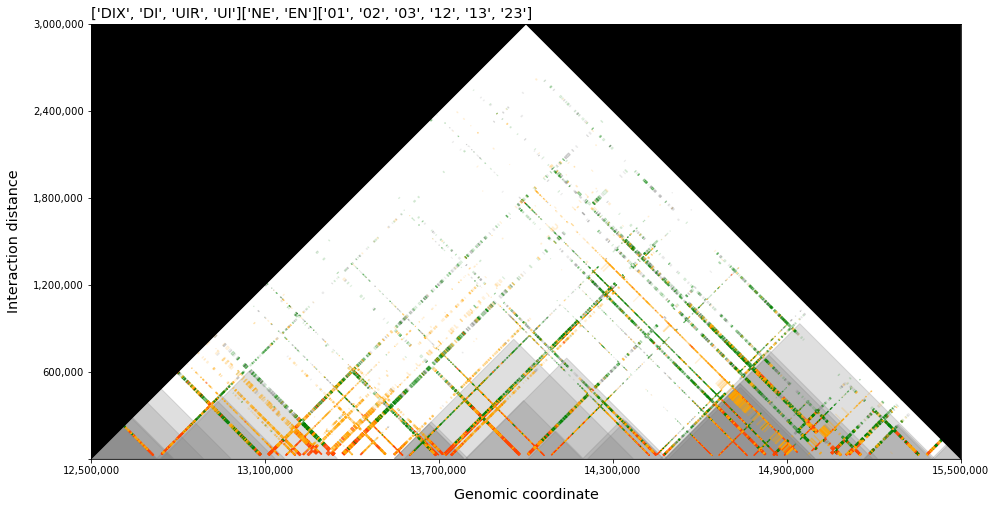

In [10]:
chrom = 'chr10'
begin = 12500000
end = begin + 3000000
visualizer.create_visualization(chrom = chrom,
                                begin = begin,
                                end = end)

In priciple, this plot corresponds to a typical represenation of Hi-C interactions. The genomic coordinates are plotted on the x-axis and each colored tetragon in the triangle above represents an interaction between two genomic regions. For Hi-C data, the interactions are typically grouped in bins of the same size, so that all tetragon are squares.

This plot shows capture Hi-C interactions between `HindIII` restriction fragments. Because restriction fragments are of different lengths, the tetragons are rectangular. The data was not corrected for distance-dependent interaction frequencies, so that the interactions spread out from the baits to the left and right. The four interaction categories `DIX` (orangered), `DI` (orange), `UIR` (green) and `UI` (gray) are shown in different colors. The TAD regions are shown as transparent triangles in the background. In this case, we have loaded the file with the TAD regions from all eight cell types, so that a genomic region can be covered by several TADs. Due to the transparent display of TADs, the gray triangles over such regions are darker.

It is also possible to plot only a certain selection of interaction categories. For this purpose, a list with the corresponding interaction categories must be passed to the function.

[INFO] Extracted 12374 interactions in range chr10:12500000-15500000
[INFO] Read pair count quantiles:
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
	[INFO] [  6.   8.   9.  11.  13.  16.  20.  26.  42. 446.]
[INFO] Got 7510 interactions
[INFO] begin: 12500000
[INFO] end: 15500000
[TEST] pos_to_coordinate(begin): 0.0
[TEST] pos_to_coordinate(end): 10.0
[TEST] coordinate_to_pos(pos_to_coordinate(begin)): 12500000.0
[TEST] coordinate_to_pos(pos_to_coordinate(end)): 15500000.0


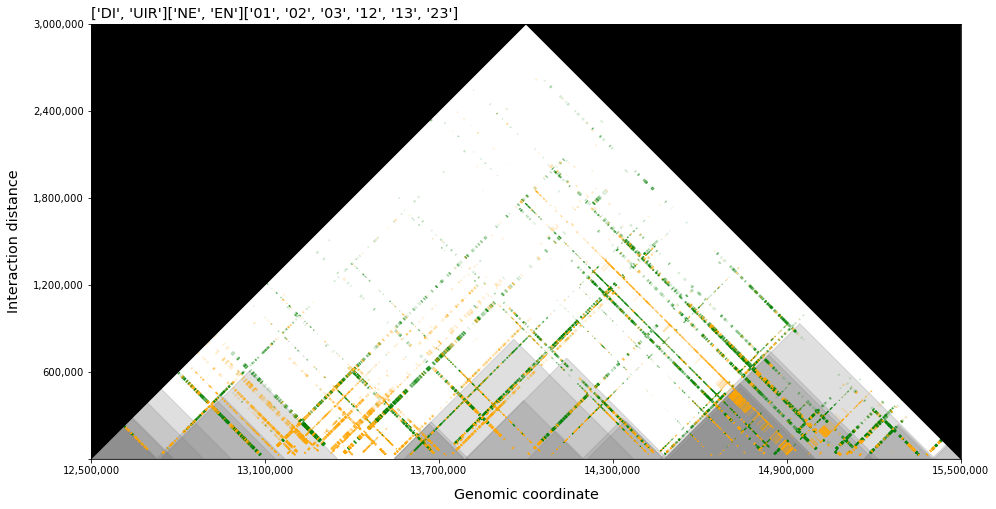

In [11]:
visualizer.create_visualization(chrom = chrom,
                                begin = begin,
                                end = end,
                                inter_cat_list = ['DI', 'UIR'])

### Compare interaction categories for one cell type in a specific region

[INFO] Extracted 7149 interactions in range chr10:12500000-15500000
[INFO] Read pair count quantiles:
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
	[INFO] [ 46.   55.   66.   82.   94.5 111.  134.  165.6 227.6 601. ]
[INFO] Got 678 interactions
[INFO] begin: 12500000
[INFO] end: 15500000
[TEST] pos_to_coordinate(begin): 0.0
[TEST] pos_to_coordinate(end): 10.0
[TEST] coordinate_to_pos(pos_to_coordinate(begin)): 12500000.0
[TEST] coordinate_to_pos(pos_to_coordinate(end)): 15500000.0


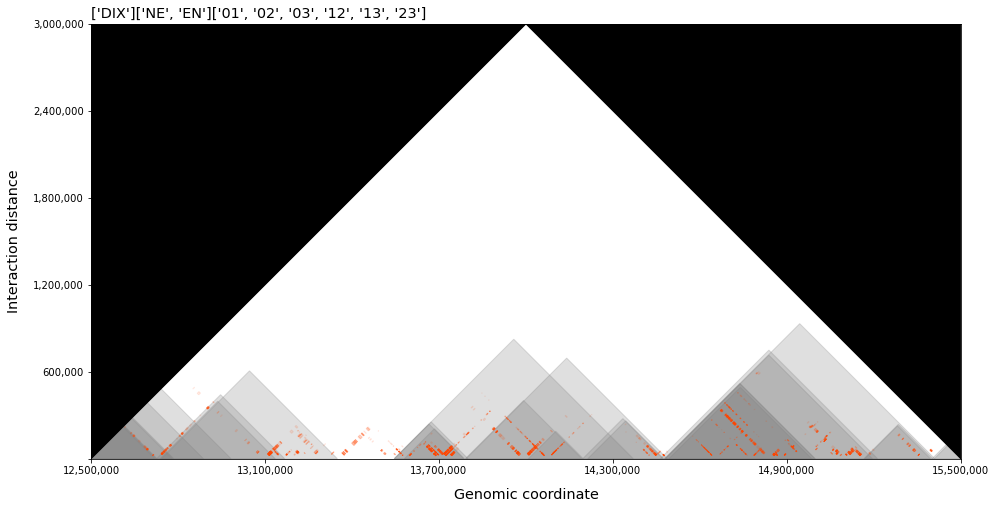

[INFO] Extracted 7149 interactions in range chr10:12500000-15500000
[INFO] Read pair count quantiles:
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
	[INFO] [ 10.  12.  14.  16.  20.  26.  35.  48.  75. 335.]
[INFO] Got 2171 interactions
[INFO] begin: 12500000
[INFO] end: 15500000
[TEST] pos_to_coordinate(begin): 0.0
[TEST] pos_to_coordinate(end): 10.0
[TEST] coordinate_to_pos(pos_to_coordinate(begin)): 12500000.0
[TEST] coordinate_to_pos(pos_to_coordinate(end)): 15500000.0


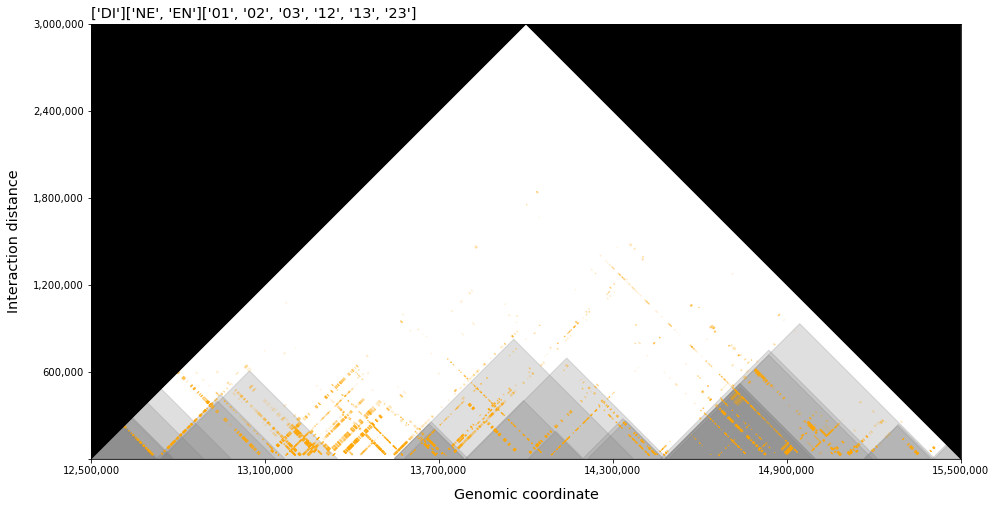

[INFO] Extracted 7149 interactions in range chr10:12500000-15500000
[INFO] Read pair count quantiles:
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
	[INFO] [ 10.  12.  14.  17.  20.  24.  30.  40.  59. 306.]
[INFO] Got 2422 interactions
[INFO] begin: 12500000
[INFO] end: 15500000
[TEST] pos_to_coordinate(begin): 0.0
[TEST] pos_to_coordinate(end): 10.0
[TEST] coordinate_to_pos(pos_to_coordinate(begin)): 12500000.0
[TEST] coordinate_to_pos(pos_to_coordinate(end)): 15500000.0


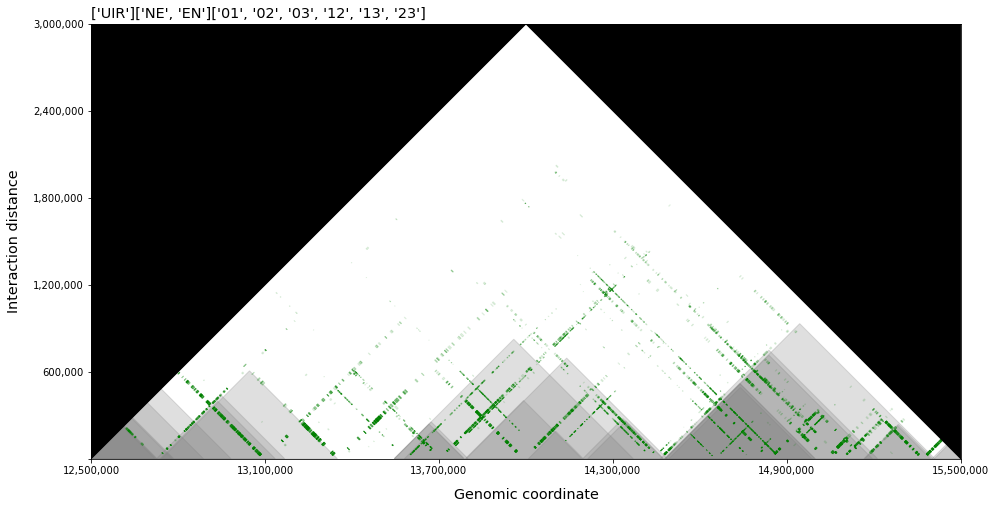

[INFO] Extracted 7149 interactions in range chr10:12500000-15500000
[INFO] Read pair count quantiles:
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
	[INFO] [ 9.  9. 10. 11. 11. 12. 13. 15. 17. 29.]
[INFO] Got 1163 interactions
[INFO] begin: 12500000
[INFO] end: 15500000
[TEST] pos_to_coordinate(begin): 0.0
[TEST] pos_to_coordinate(end): 10.0
[TEST] coordinate_to_pos(pos_to_coordinate(begin)): 12500000.0
[TEST] coordinate_to_pos(pos_to_coordinate(end)): 15500000.0


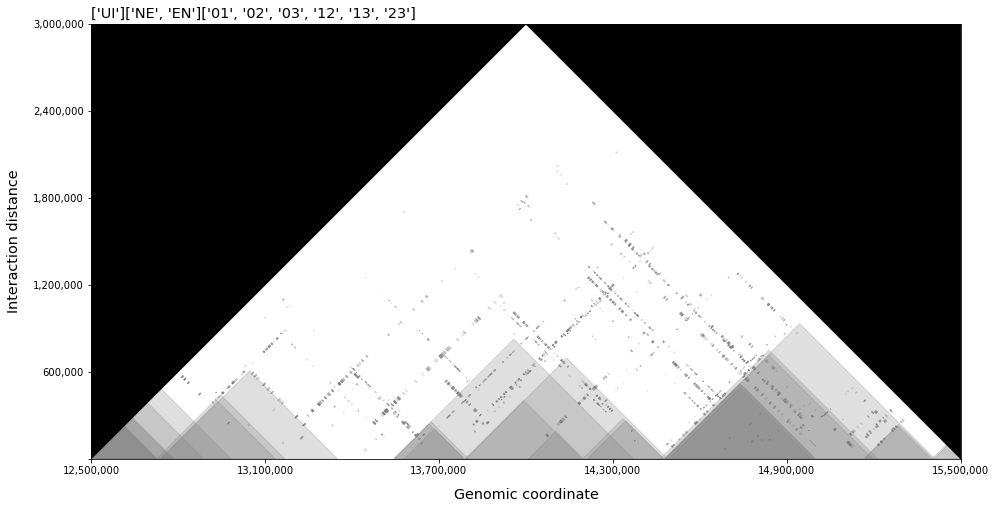

In [65]:
chrom = 'chr10'
begin = 12500000
end = begin + 3000000
for i_cat in ['DIX','DI','UIR','UI']:
    visualizer.create_visualization(chrom = chrom,
                                    begin = begin,
                                    end = end,
                                    inter_cat_list = [i_cat],
                                    enr_cat_list = ['NE','EN'],
                                    #ht_tag_list = ['12','03'],
                                    #ht_tag_list = ['13','02'],
                                    color_i_cats = True)

### Slide a window over a chromosome

[INFO] Extracted 312 interactions in range chr5:20000000-22500000
[INFO] Read pair count quantiles:
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
	[INFO] [38.8 41.6 44.  46.  48.  49.6 51.2 57.  67.  77. ]
[INFO] Got 5 interactions
[INFO] begin: 20000000
[INFO] end: 22500000
[TEST] pos_to_coordinate(begin): 0.0
[TEST] pos_to_coordinate(end): 10.0
[TEST] coordinate_to_pos(pos_to_coordinate(begin)): 20000000.0
[TEST] coordinate_to_pos(pos_to_coordinate(end)): 22500000.0


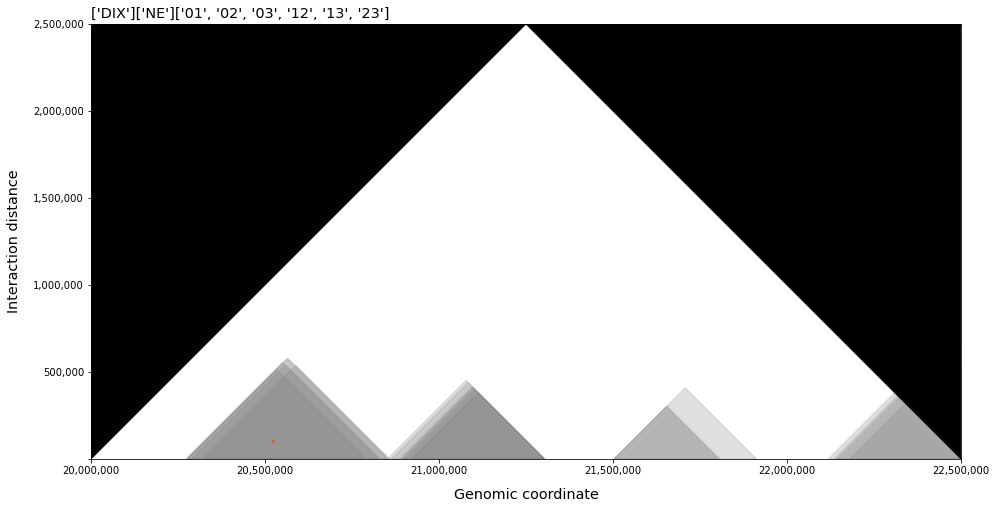

[INFO] Extracted 312 interactions in range chr5:20000000-22500000
[INFO] Read pair count quantiles:
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
	[INFO] [ 10.   11.2  12.   14.   16.   18.   20.   27.   61.9 116. ]
[INFO] Got 52 interactions
[INFO] begin: 20000000
[INFO] end: 22500000
[TEST] pos_to_coordinate(begin): 0.0
[TEST] pos_to_coordinate(end): 10.0
[TEST] coordinate_to_pos(pos_to_coordinate(begin)): 20000000.0
[TEST] coordinate_to_pos(pos_to_coordinate(end)): 22500000.0


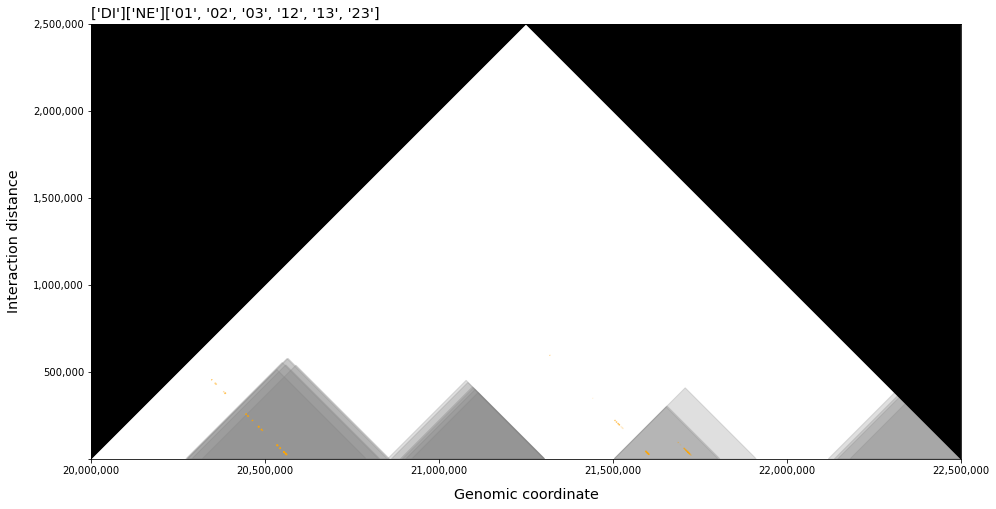

[INFO] Extracted 312 interactions in range chr5:20000000-22500000
[INFO] Read pair count quantiles:
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
	[INFO] [ 13.7  16.   19.1  22.8  26.5  29.2  34.   40.   51.  148. ]
[INFO] Got 68 interactions
[INFO] begin: 20000000
[INFO] end: 22500000
[TEST] pos_to_coordinate(begin): 0.0
[TEST] pos_to_coordinate(end): 10.0
[TEST] coordinate_to_pos(pos_to_coordinate(begin)): 20000000.0
[TEST] coordinate_to_pos(pos_to_coordinate(end)): 22500000.0


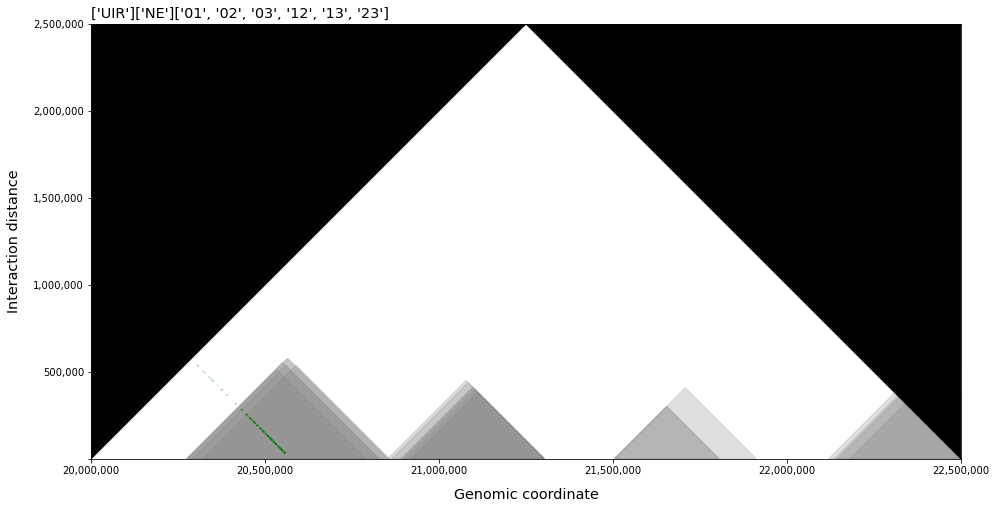

[INFO] Extracted 312 interactions in range chr5:20000000-22500000
[INFO] Read pair count quantiles:
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
	[INFO] [ 9.9 10.  10.7 11.  13.  13.4 17.  17.2 19.3 26. ]
[INFO] Got 30 interactions
[INFO] begin: 20000000
[INFO] end: 22500000
[TEST] pos_to_coordinate(begin): 0.0
[TEST] pos_to_coordinate(end): 10.0
[TEST] coordinate_to_pos(pos_to_coordinate(begin)): 20000000.0
[TEST] coordinate_to_pos(pos_to_coordinate(end)): 22500000.0


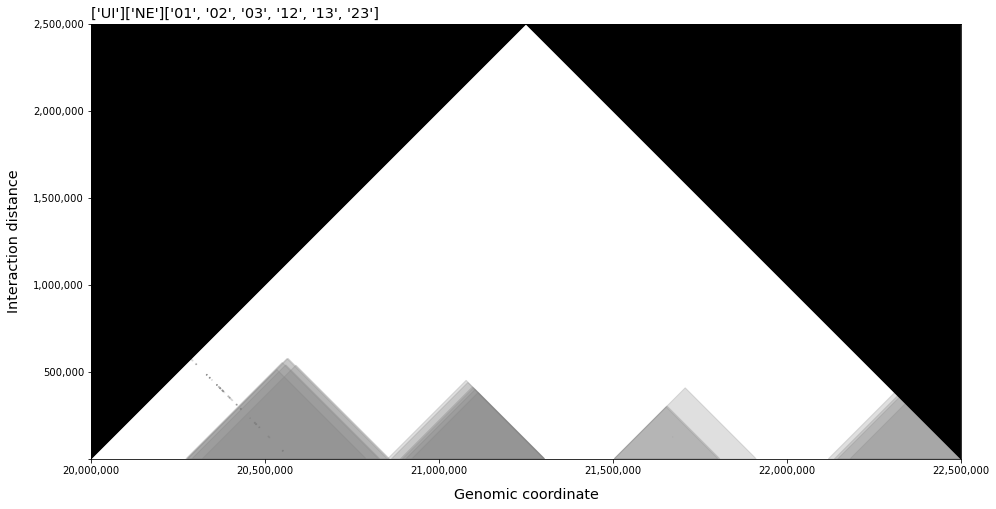

[INFO] Extracted 1263 interactions in range chr5:22500000-25000000
[INFO] Read pair count quantiles:
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
	[INFO] [ 44.2  48.   51.   67.4  76.   90.8 108.4 127.  159.  185. ]
[INFO] Got 37 interactions
[INFO] begin: 22500000
[INFO] end: 25000000
[TEST] pos_to_coordinate(begin): 0.0
[TEST] pos_to_coordinate(end): 10.0
[TEST] coordinate_to_pos(pos_to_coordinate(begin)): 22500000.0
[TEST] coordinate_to_pos(pos_to_coordinate(end)): 25000000.0


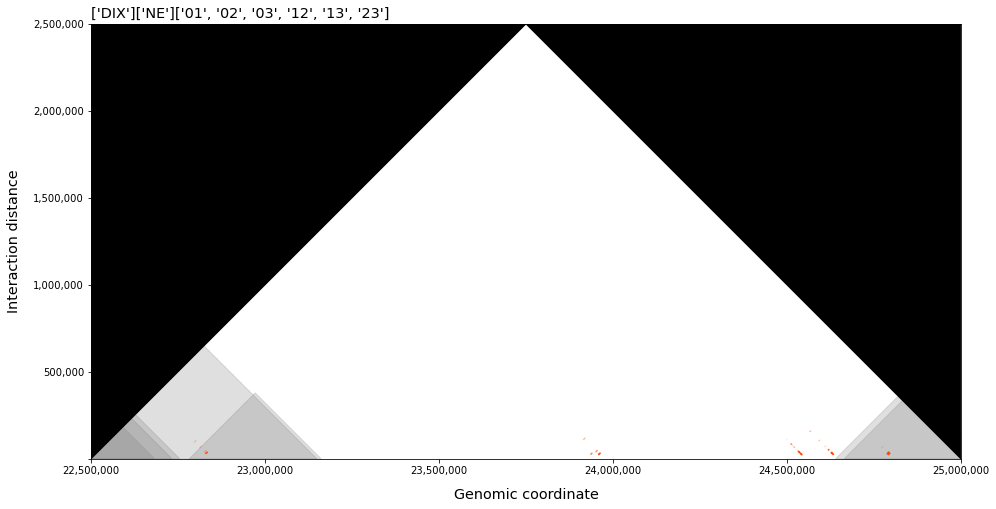

[INFO] Extracted 1263 interactions in range chr5:22500000-25000000
[INFO] Read pair count quantiles:
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
	[INFO] [  9.6  11.   12.   14.   17.   19.6  24.   31.   48.8 151. ]
[INFO] Got 197 interactions
[INFO] begin: 22500000
[INFO] end: 25000000
[TEST] pos_to_coordinate(begin): 0.0
[TEST] pos_to_coordinate(end): 10.0
[TEST] coordinate_to_pos(pos_to_coordinate(begin)): 22500000.0
[TEST] coordinate_to_pos(pos_to_coordinate(end)): 25000000.0


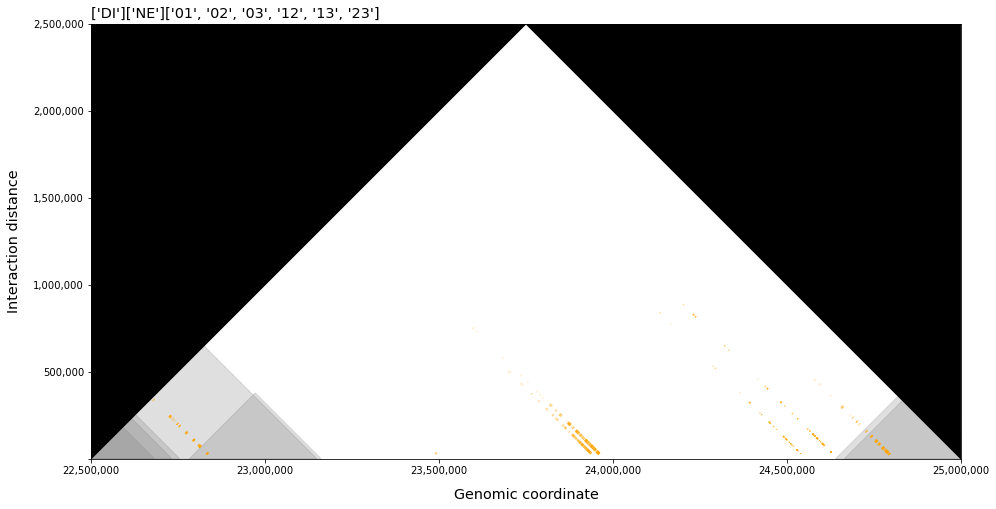

[INFO] Extracted 1263 interactions in range chr5:22500000-25000000
[INFO] Read pair count quantiles:
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
	[INFO] [ 10.8  13.   15.   18.   20.   25.   29.   35.4  46.  106. ]
[INFO] Got 289 interactions
[INFO] begin: 22500000
[INFO] end: 25000000
[TEST] pos_to_coordinate(begin): 0.0
[TEST] pos_to_coordinate(end): 10.0
[TEST] coordinate_to_pos(pos_to_coordinate(begin)): 22500000.0
[TEST] coordinate_to_pos(pos_to_coordinate(end)): 25000000.0


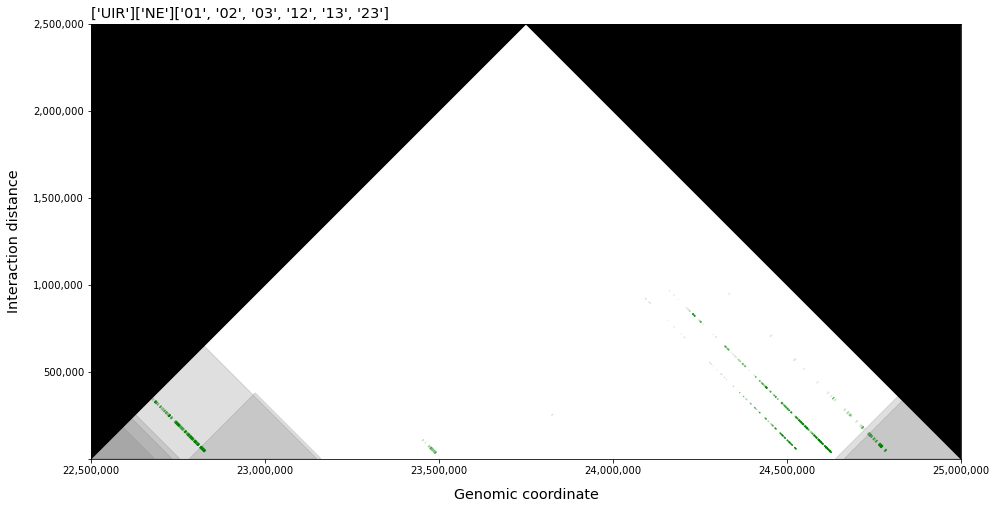

[INFO] Extracted 1263 interactions in range chr5:22500000-25000000
[INFO] Read pair count quantiles:
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
	[INFO] [ 9. 10. 10. 11. 11. 12. 14. 16. 18. 29.]
[INFO] Got 128 interactions
[INFO] begin: 22500000
[INFO] end: 25000000
[TEST] pos_to_coordinate(begin): 0.0
[TEST] pos_to_coordinate(end): 10.0
[TEST] coordinate_to_pos(pos_to_coordinate(begin)): 22500000.0
[TEST] coordinate_to_pos(pos_to_coordinate(end)): 25000000.0


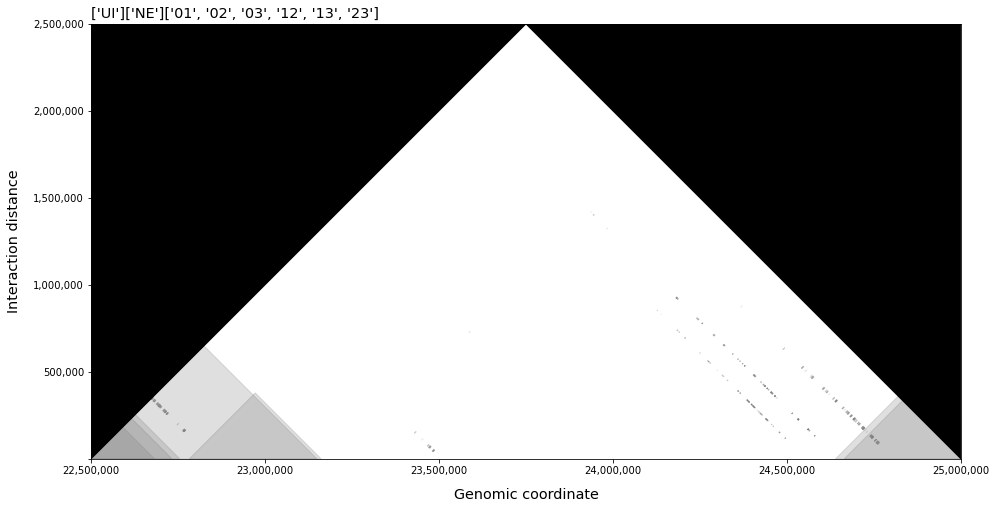

[INFO] Extracted 418 interactions in range chr5:25000000-27500000
[INFO] Read pair count quantiles:
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
	[INFO] [ 39.   43.   48.6  55.8  63.   66.2  69.4  77.8  91.4 105. ]
[INFO] Got 5 interactions
[INFO] begin: 25000000
[INFO] end: 27500000
[TEST] pos_to_coordinate(begin): 0.0
[TEST] pos_to_coordinate(end): 10.0
[TEST] coordinate_to_pos(pos_to_coordinate(begin)): 25000000.0
[TEST] coordinate_to_pos(pos_to_coordinate(end)): 27500000.0


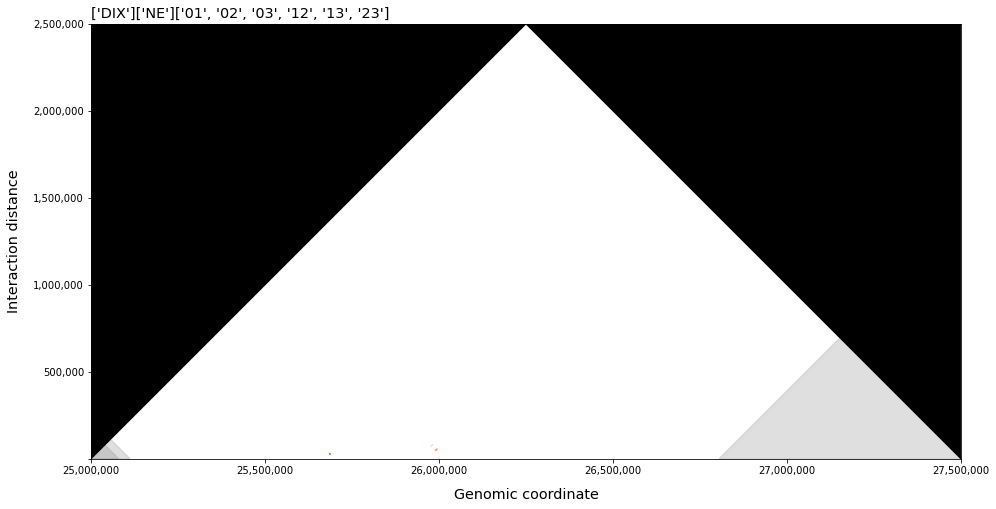

[INFO] Extracted 418 interactions in range chr5:25000000-27500000
[INFO] Read pair count quantiles:
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
	[INFO] [  9.   10.   11.5  13.   14.5  17.   20.   24.   34.5 115. ]
[INFO] Got 96 interactions
[INFO] begin: 25000000
[INFO] end: 27500000
[TEST] pos_to_coordinate(begin): 0.0
[TEST] pos_to_coordinate(end): 10.0
[TEST] coordinate_to_pos(pos_to_coordinate(begin)): 25000000.0
[TEST] coordinate_to_pos(pos_to_coordinate(end)): 27500000.0


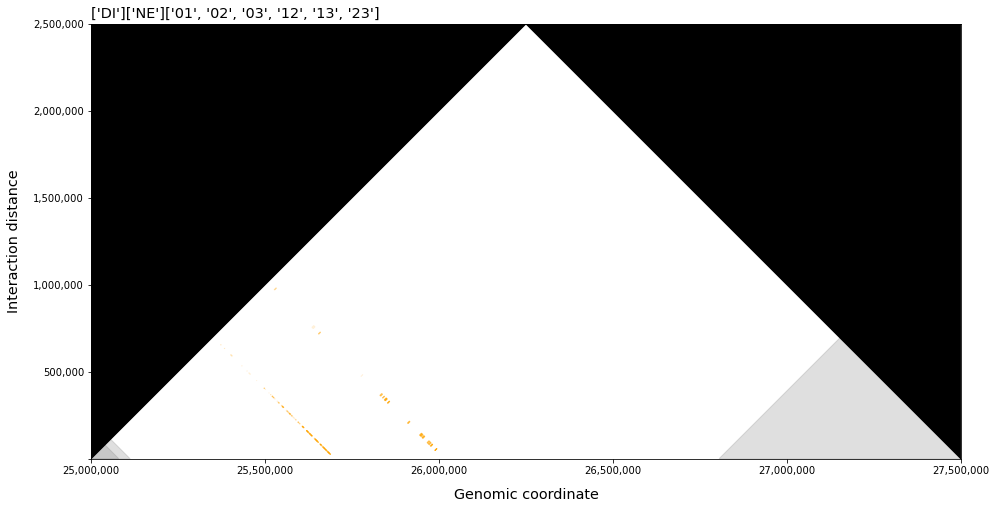

[INFO] Extracted 418 interactions in range chr5:25000000-27500000
[INFO] Read pair count quantiles:
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
	[INFO] [ 9. 10. 10. 12. 14. 15. 16. 21. 33. 67.]
[INFO] Got 71 interactions
[INFO] begin: 25000000
[INFO] end: 27500000
[TEST] pos_to_coordinate(begin): 0.0
[TEST] pos_to_coordinate(end): 10.0
[TEST] coordinate_to_pos(pos_to_coordinate(begin)): 25000000.0
[TEST] coordinate_to_pos(pos_to_coordinate(end)): 27500000.0


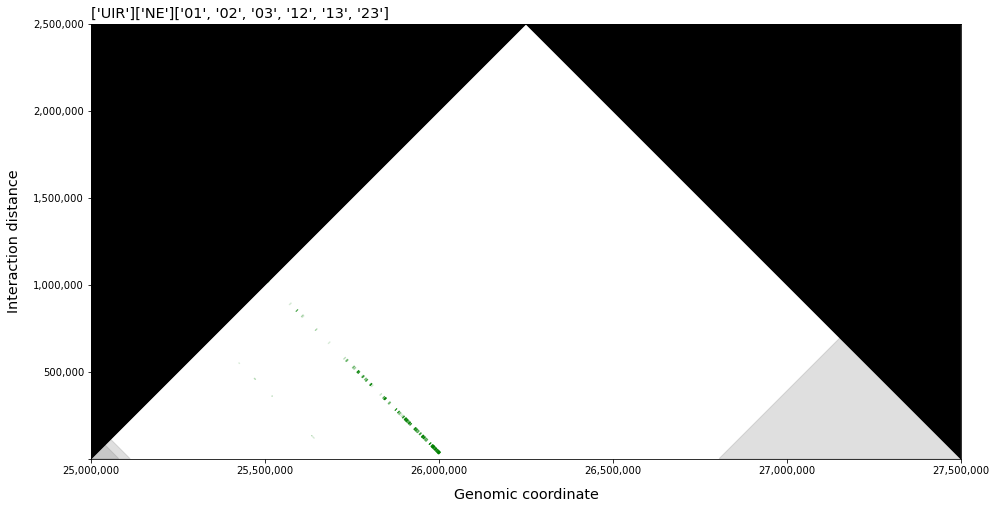

[INFO] Extracted 418 interactions in range chr5:25000000-27500000
[INFO] Read pair count quantiles:
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
	[INFO] [ 9.   9.  10.  10.4 11.  11.6 13.  13.  18.  25. ]
[INFO] Got 37 interactions
[INFO] begin: 25000000
[INFO] end: 27500000
[TEST] pos_to_coordinate(begin): 0.0
[TEST] pos_to_coordinate(end): 10.0
[TEST] coordinate_to_pos(pos_to_coordinate(begin)): 25000000.0
[TEST] coordinate_to_pos(pos_to_coordinate(end)): 27500000.0


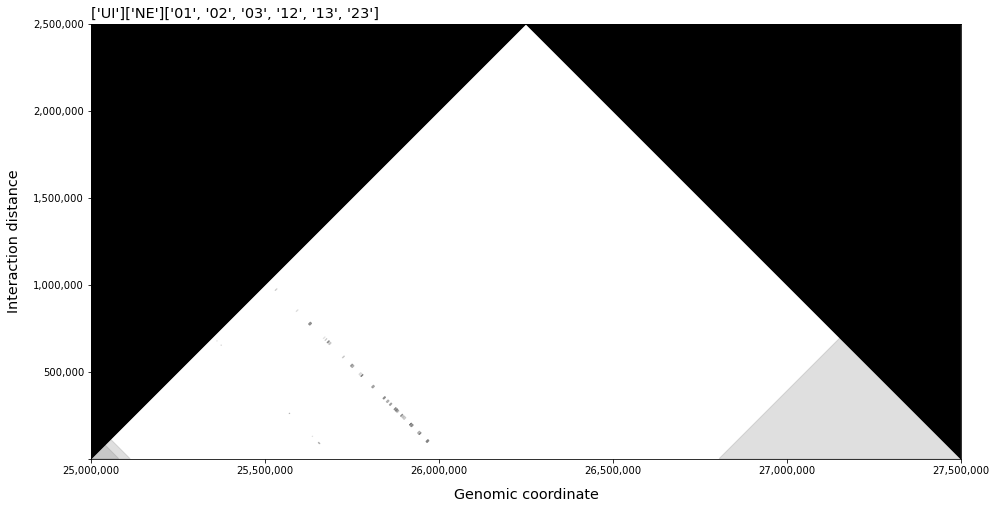

[INFO] Extracted 145 interactions in range chr5:27500000-30000000
[INFO] Read pair count quantiles:
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
	[INFO] [51.2 52.4 53.6 54.8 56.  57.2 58.4 59.6 60.8 62. ]
[INFO] Got 2 interactions
[INFO] begin: 27500000
[INFO] end: 30000000
[TEST] pos_to_coordinate(begin): 0.0
[TEST] pos_to_coordinate(end): 10.0
[TEST] coordinate_to_pos(pos_to_coordinate(begin)): 27500000.0
[TEST] coordinate_to_pos(pos_to_coordinate(end)): 30000000.0


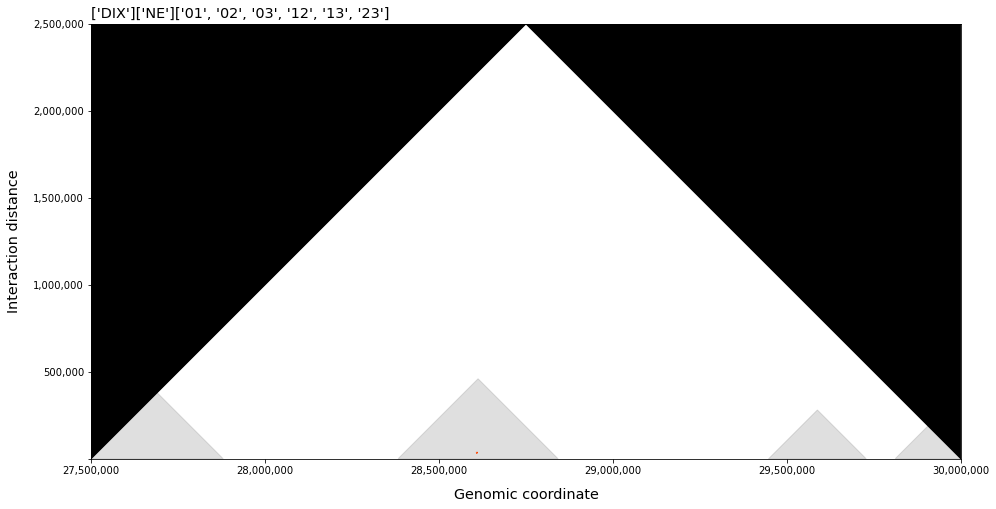

[INFO] Extracted 145 interactions in range chr5:27500000-30000000
[INFO] Read pair count quantiles:
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
	[INFO] [ 9.  10.  10.7 12.  14.  15.4 19.  22.  29.  83. ]
[INFO] Got 70 interactions
[INFO] begin: 27500000
[INFO] end: 30000000
[TEST] pos_to_coordinate(begin): 0.0
[TEST] pos_to_coordinate(end): 10.0
[TEST] coordinate_to_pos(pos_to_coordinate(begin)): 27500000.0
[TEST] coordinate_to_pos(pos_to_coordinate(end)): 30000000.0


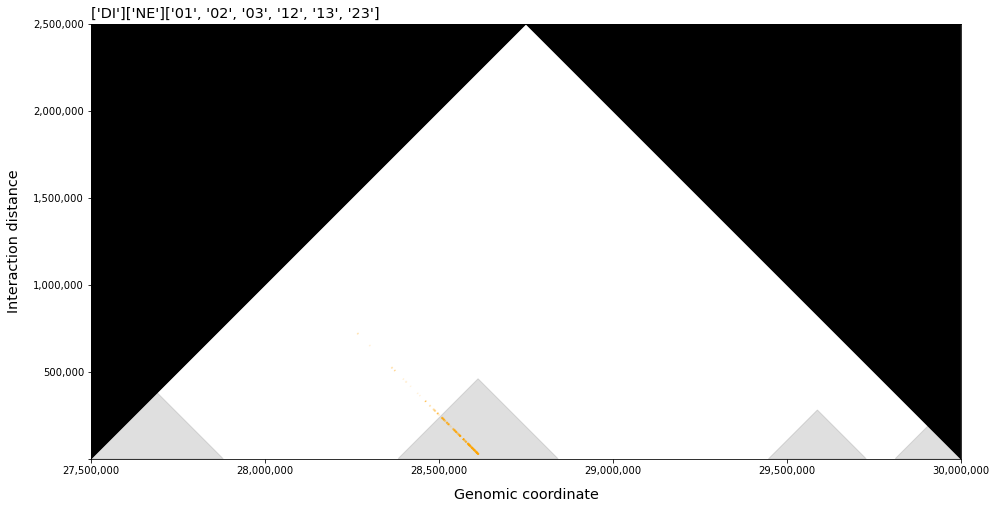

[INFO] Extracted 145 interactions in range chr5:27500000-30000000
[INFO] Read pair count quantiles:
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
	[INFO] [10. 11. 12. 13. 14. 15. 16. 17. 18. 19.]
[INFO] Got 2 interactions
[INFO] begin: 27500000
[INFO] end: 30000000
[TEST] pos_to_coordinate(begin): 0.0
[TEST] pos_to_coordinate(end): 10.0
[TEST] coordinate_to_pos(pos_to_coordinate(begin)): 27500000.0
[TEST] coordinate_to_pos(pos_to_coordinate(end)): 30000000.0


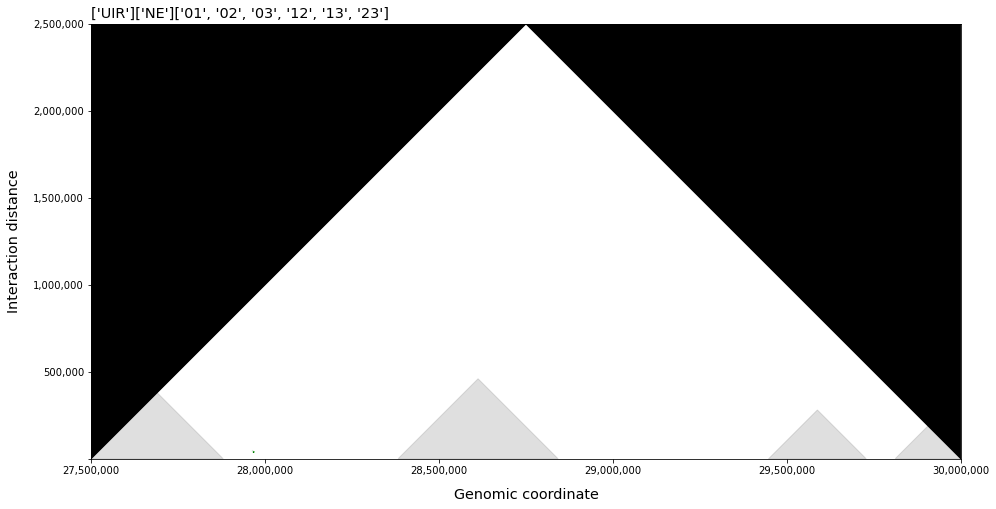

[INFO] Extracted 145 interactions in range chr5:27500000-30000000
[INFO] Read pair count quantiles:
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
	[INFO] [ 9.   9.   9.   9.   9.   9.6 10.2 10.8 11.4 12. ]
[INFO] Got 3 interactions
[INFO] begin: 27500000
[INFO] end: 30000000
[TEST] pos_to_coordinate(begin): 0.0
[TEST] pos_to_coordinate(end): 10.0
[TEST] coordinate_to_pos(pos_to_coordinate(begin)): 27500000.0
[TEST] coordinate_to_pos(pos_to_coordinate(end)): 30000000.0


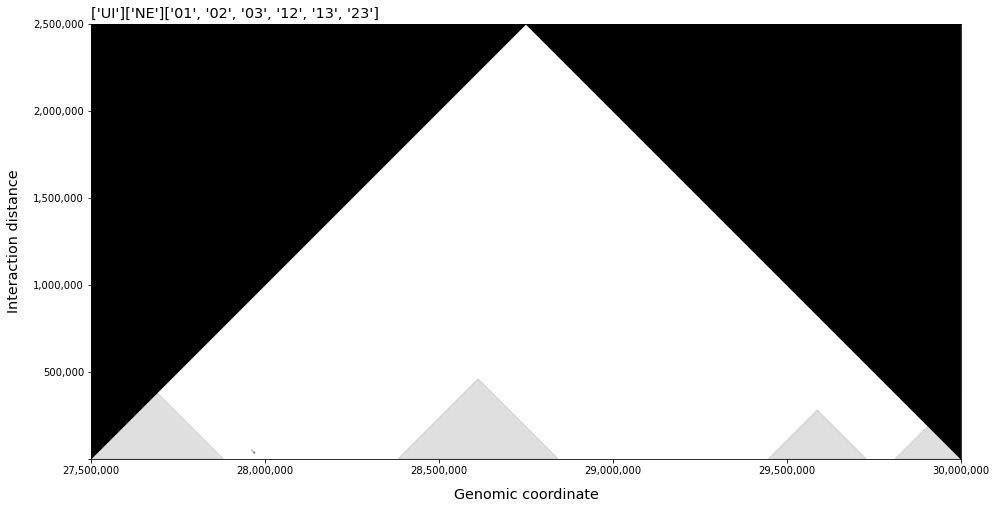

In [62]:
chrom = 'chr5'
for start_pos in range(20000000,30000000,2500000):
    begin = start_pos
    end = begin + 2500000
    for i_cat in ['DIX','DI','UIR','UI']:
        visualizer.create_visualization(chrom = chrom,
                                        begin = begin,
                                        end = end,
                                        inter_cat_list = [i_cat],
                                        enr_cat_list = ['NE'],
                                        #ht_tag_list = ['12','03'],
                                        #ht_tag_list = ['13','02'],
                                        color_i_cats = True)

### Compare HT tags

In [30]:
visualizer_1 = DirectedTadVisualizer(i_file=INTERACTION_FILE_1, t_file=TAD_BED_FILE)
visualizer_2 = DirectedTadVisualizer(i_file=INTERACTION_FILE_2, t_file=TAD_BED_FILE)

NameError: name 'INTERACTION_FILE_1' is not defined

[INFO] Extracted 9312 interactions in range chr10:5000000-10000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  17.  20.  24.  29.  38.  57. 315.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 5000000 max: 10000000
[INFO] Got 1100 digests
[INFO] Got 3205 interactions
[INFO] begin:5000000
[INFO] end:10000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


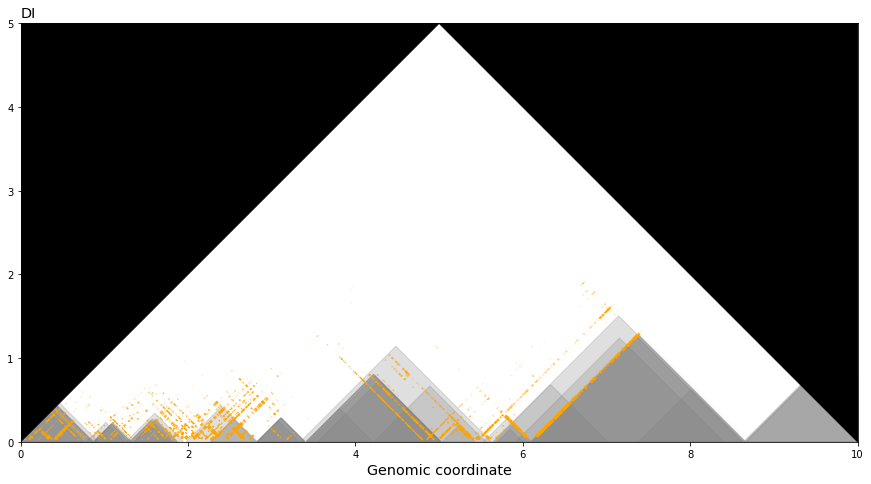

[INFO] Extracted 8572 interactions in range chr10:5000000-10000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  13.  15.  18.  22.  27.  35.  53. 338.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 5000000 max: 10000000
[INFO] Got 978 digests
[INFO] Got 2739 interactions
[INFO] begin:5000000
[INFO] end:10000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


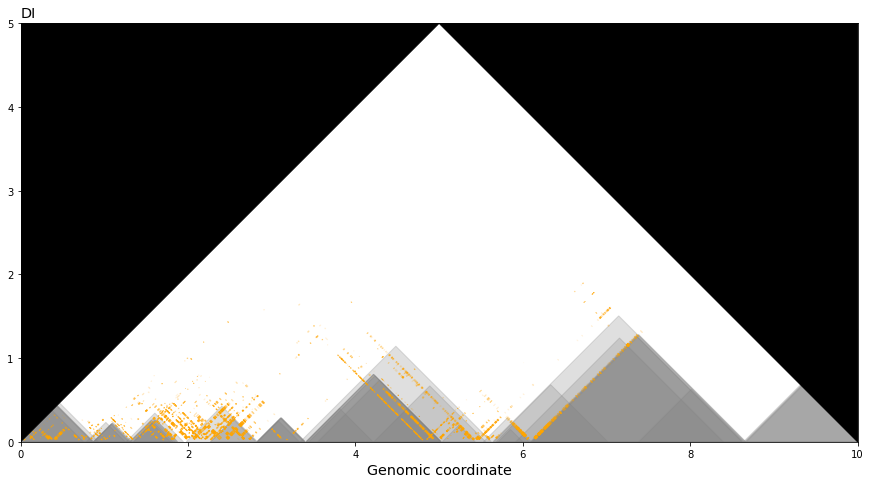

[INFO] Extracted 7749 interactions in range chr10:7500000-12500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  16.  19.  23.  28.  37.  56. 376.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 7500000 max: 12500000
[INFO] Got 1265 digests
[INFO] Got 3589 interactions
[INFO] begin:7500000
[INFO] end:12500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


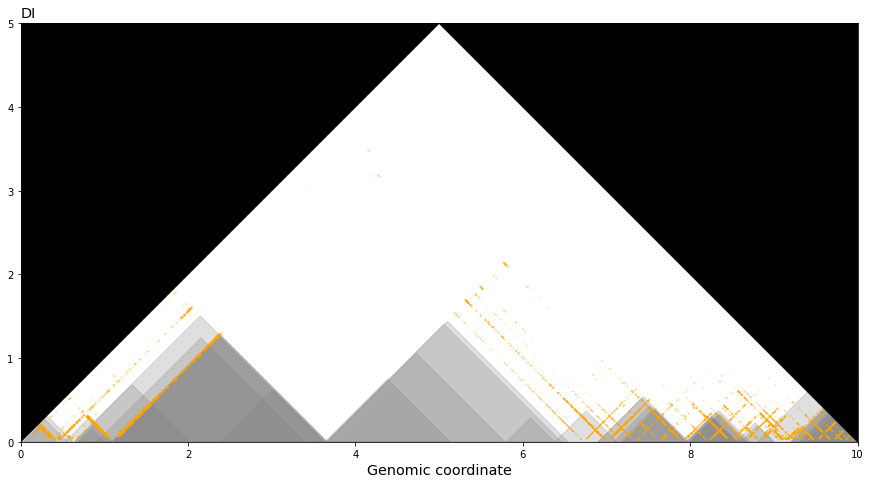

[INFO] Extracted 6078 interactions in range chr10:7500000-12500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  11.  13.  15.  18.  22.  27.  35.  52. 427.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 7500000 max: 12500000
[INFO] Got 963 digests
[INFO] Got 2791 interactions
[INFO] begin:7500000
[INFO] end:12500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


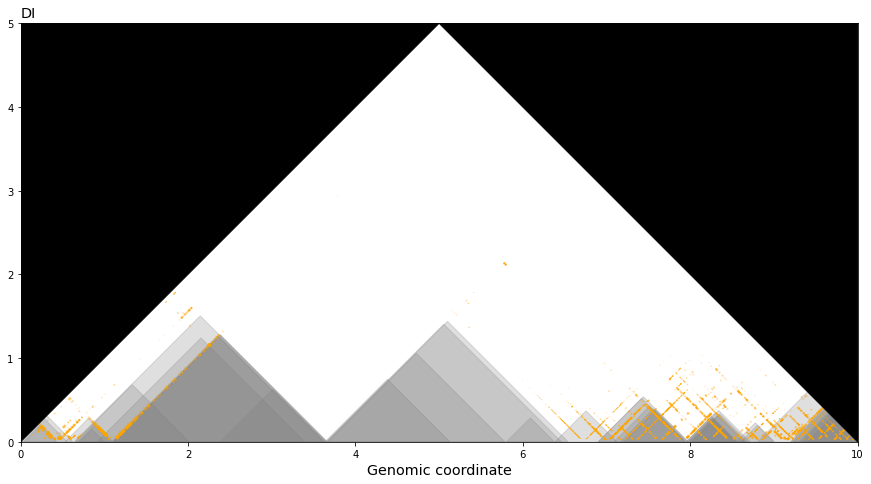

[INFO] Extracted 11832 interactions in range chr10:10000000-15000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  16.  20.  24.  30.  41.  62. 583.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 10000000 max: 15000000
[INFO] Got 1320 digests
[INFO] Got 5391 interactions
[INFO] begin:10000000
[INFO] end:15000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


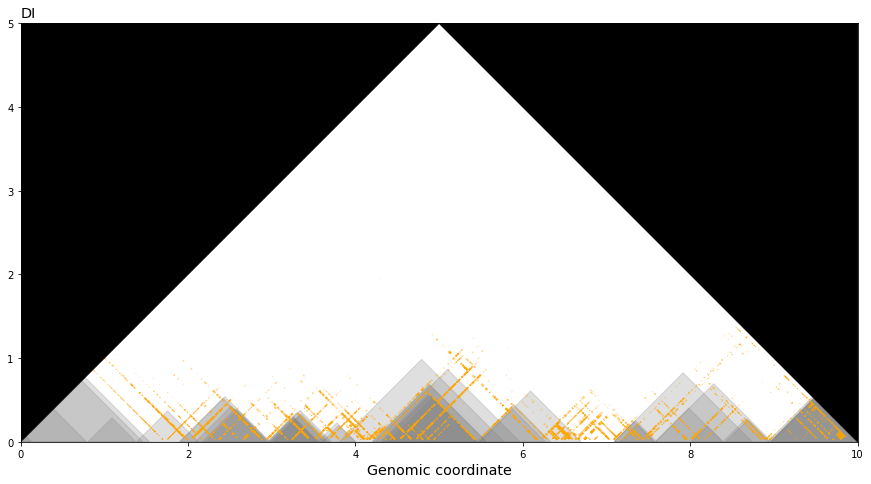

[INFO] Extracted 11821 interactions in range chr10:10000000-15000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  16.  20.  24.  30.  39.  58. 454.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 10000000 max: 15000000
[INFO] Got 1233 digests
[INFO] Got 4932 interactions
[INFO] begin:10000000
[INFO] end:15000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


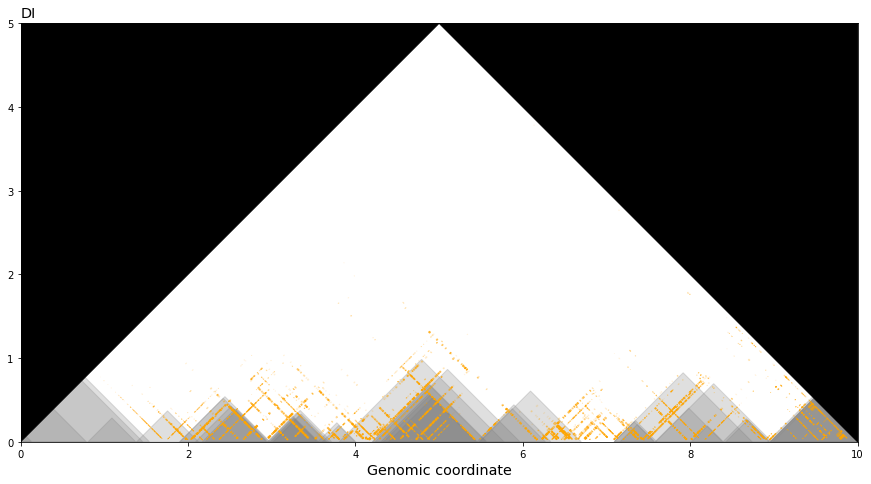

[INFO] Extracted 12622 interactions in range chr10:12500000-17500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  15.  18.  21.  27.  36.  49.  73. 583.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 12500000 max: 17500000
[INFO] Got 1265 digests
[INFO] Got 4266 interactions
[INFO] begin:12500000
[INFO] end:17500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


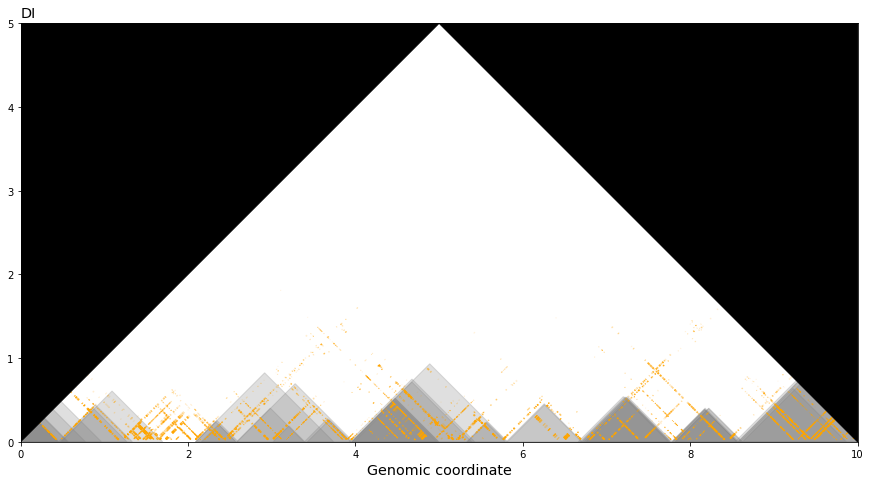

[INFO] Extracted 11430 interactions in range chr10:12500000-17500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  17.  20.  25.  31.  42.  62. 454.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 12500000 max: 17500000
[INFO] Got 1188 digests
[INFO] Got 3851 interactions
[INFO] begin:12500000
[INFO] end:17500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


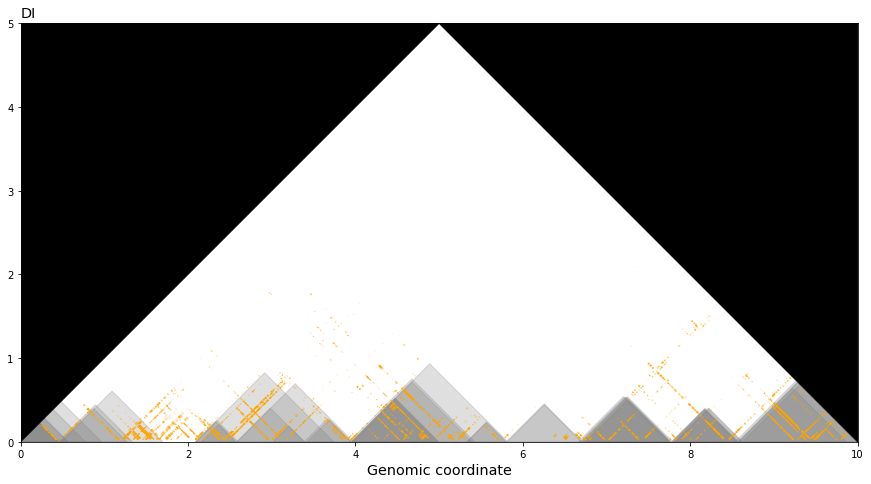

[INFO] Extracted 11238 interactions in range chr10:15000000-20000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  13.  15.  18.  22.  27.  34.  46.  71. 538.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 15000000 max: 20000000
[INFO] Got 1212 digests
[INFO] Got 3584 interactions
[INFO] begin:15000000
[INFO] end:20000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


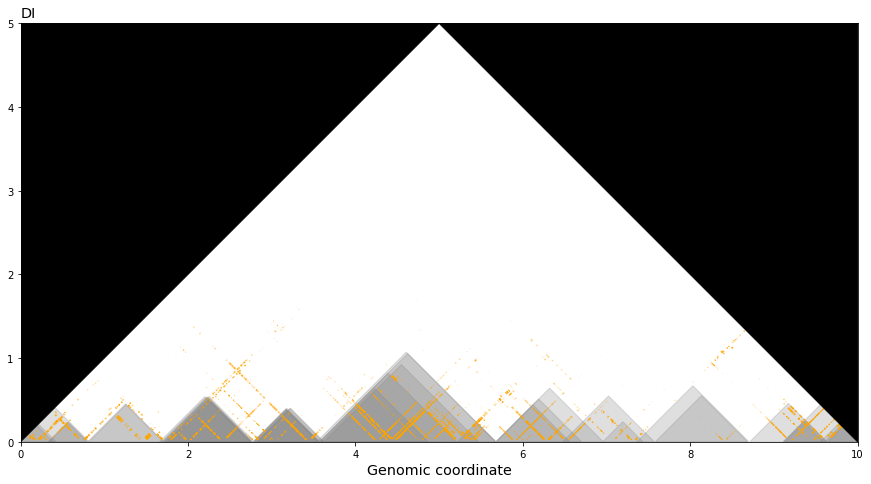

[INFO] Extracted 8775 interactions in range chr10:15000000-20000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  11.  13.  15.  18.  21.  27.  37.  58. 290.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 15000000 max: 20000000
[INFO] Got 1134 digests
[INFO] Got 2889 interactions
[INFO] begin:15000000
[INFO] end:20000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


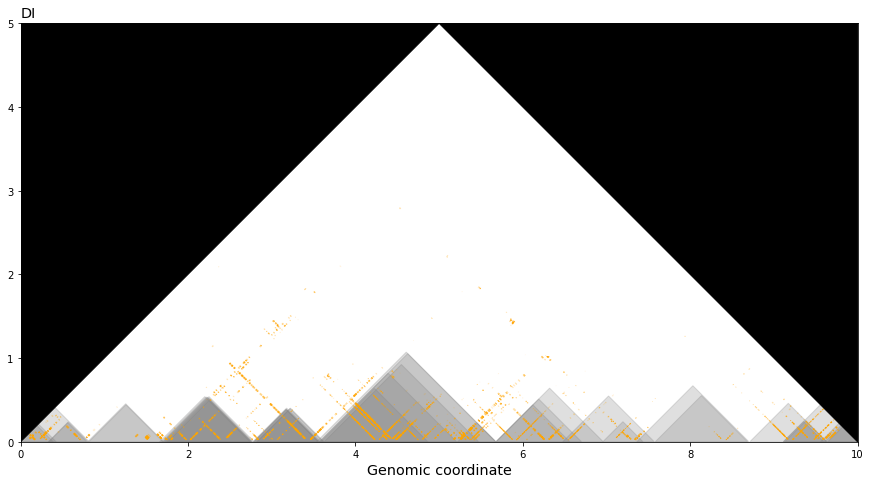

[INFO] Extracted 9159 interactions in range chr10:17500000-22500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  13.  15.  18.  22.  26.  33.  44.  66. 538.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 17500000 max: 22500000
[INFO] Got 1227 digests
[INFO] Got 2736 interactions
[INFO] begin:17500000
[INFO] end:22500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


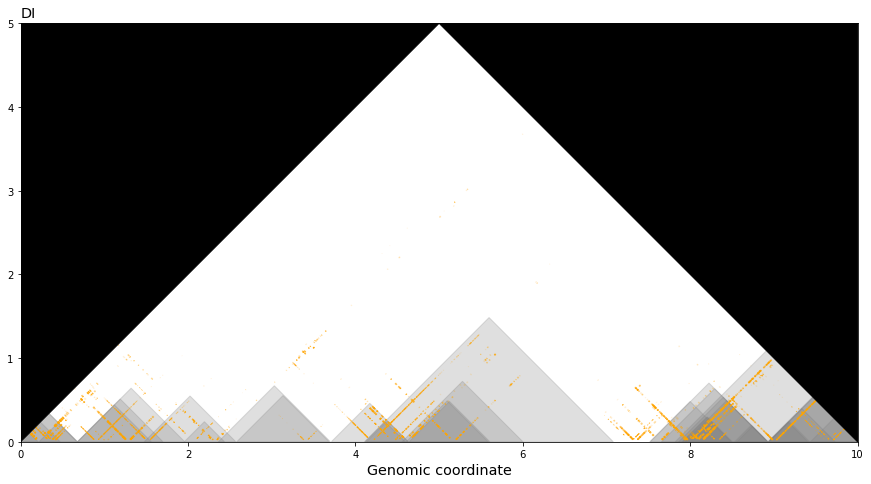

[INFO] Extracted 7351 interactions in range chr10:17500000-22500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  13.  16.  19.  23.  30.  40.  60. 618.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 17500000 max: 22500000
[INFO] Got 1064 digests
[INFO] Got 2293 interactions
[INFO] begin:17500000
[INFO] end:22500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


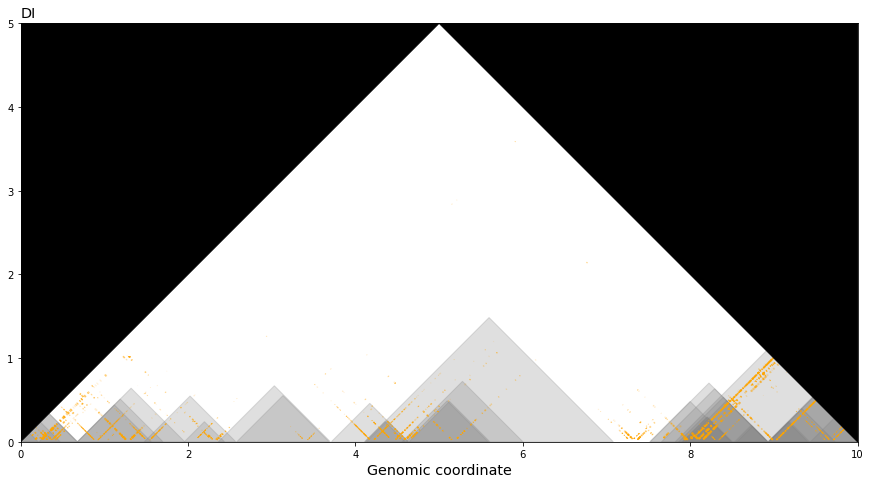

[INFO] Extracted 8612 interactions in range chr10:20000000-25000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  15.  17.  21.  25.  31.  41.  58. 439.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 20000000 max: 25000000
[INFO] Got 1096 digests
[INFO] Got 3433 interactions
[INFO] begin:20000000
[INFO] end:25000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


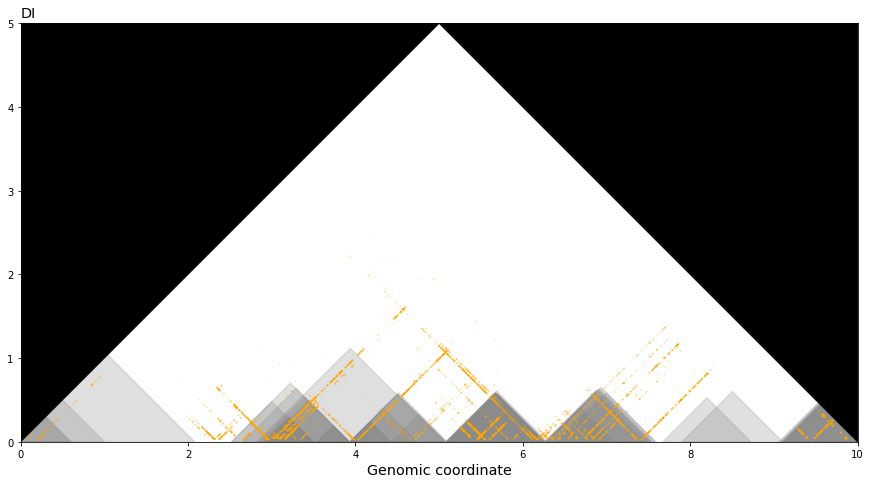

[INFO] Extracted 8724 interactions in range chr10:20000000-25000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  11.  13.  15.  18.  23.  28.  36.  53. 618.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 20000000 max: 25000000
[INFO] Got 1010 digests
[INFO] Got 3392 interactions
[INFO] begin:20000000
[INFO] end:25000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


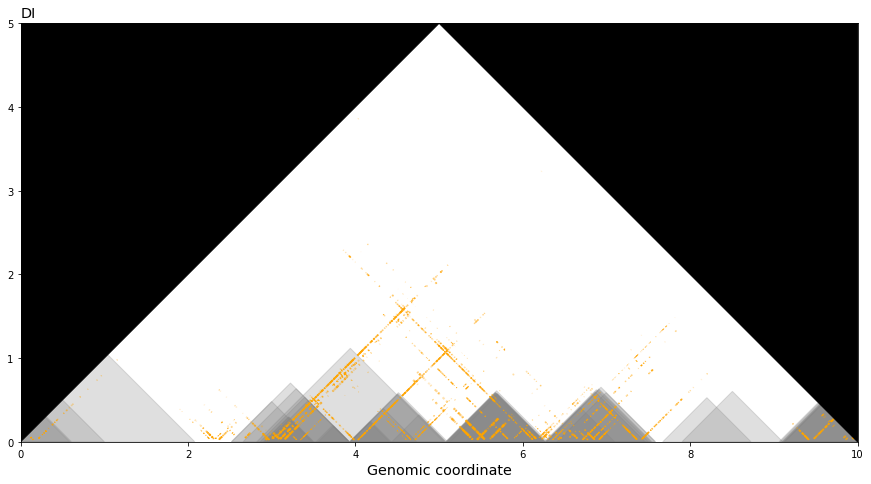

[INFO] Extracted 6993 interactions in range chr10:22500000-27500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.   12.   15.   18.   21.   25.6  31.2  41.   58.  474. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 22500000 max: 27500000
[INFO] Got 1003 digests
[INFO] Got 2477 interactions
[INFO] begin:22500000
[INFO] end:27500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


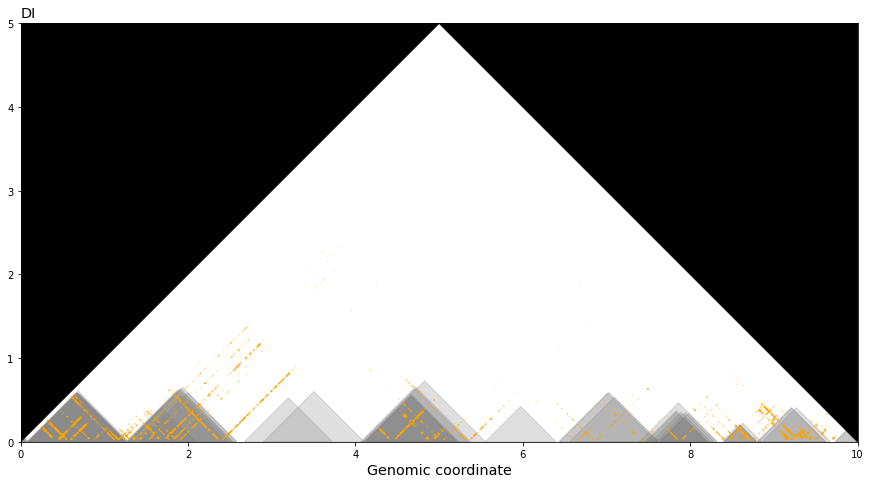

[INFO] Extracted 6291 interactions in range chr10:22500000-27500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  16.  19.  23.  28.  36.  55. 525.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 22500000 max: 27500000
[INFO] Got 958 digests
[INFO] Got 2294 interactions
[INFO] begin:22500000
[INFO] end:27500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


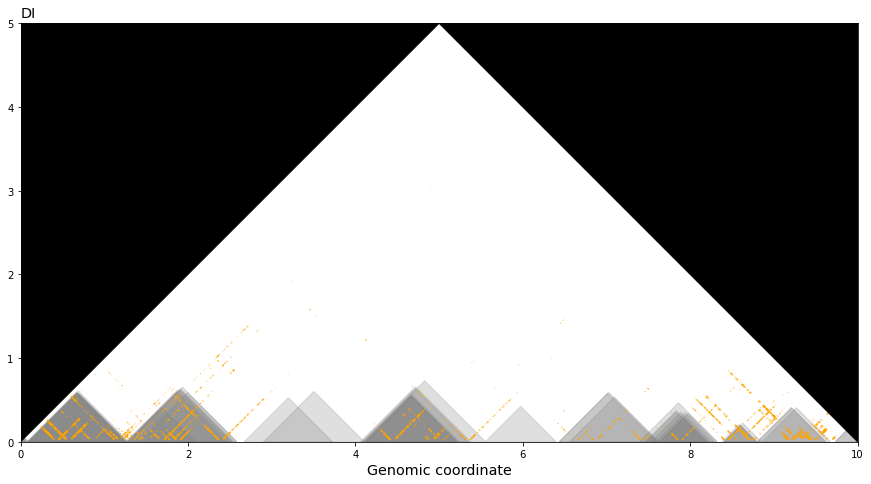

[INFO] Extracted 7180 interactions in range chr10:25000000-30000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  17.  20.  24.  31.  41.  63. 474.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 25000000 max: 30000000
[INFO] Got 1031 digests
[INFO] Got 2409 interactions
[INFO] begin:25000000
[INFO] end:30000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


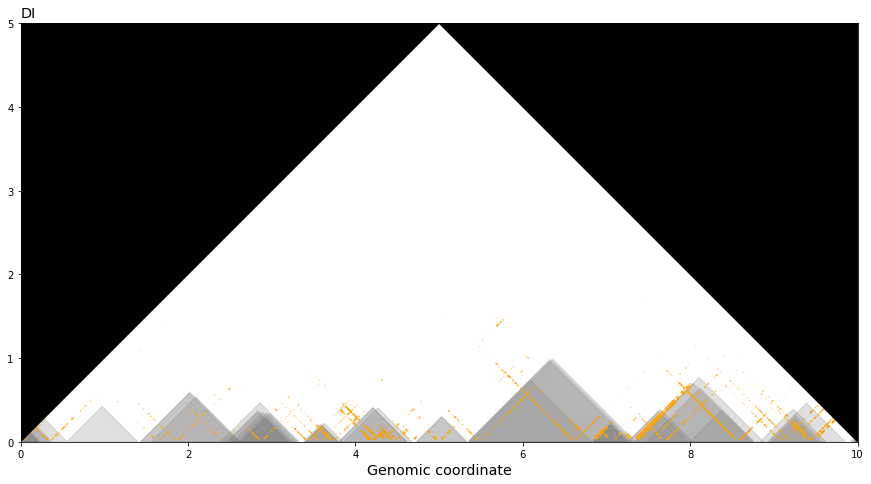

[INFO] Extracted 6222 interactions in range chr10:25000000-30000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  11.  13.  15.  18.  21.  25.  32.  50. 525.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 25000000 max: 30000000
[INFO] Got 948 digests
[INFO] Got 2045 interactions
[INFO] begin:25000000
[INFO] end:30000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


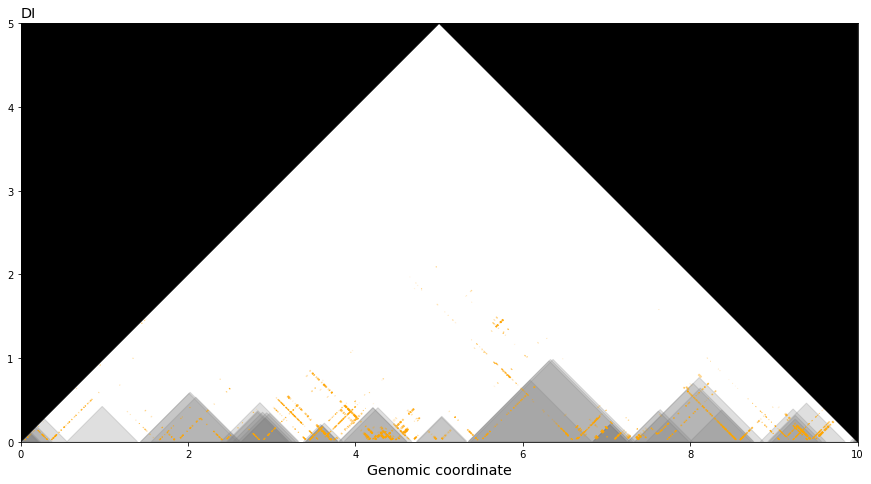

[INFO] Extracted 6627 interactions in range chr10:27500000-32500000
[INFO] Read pair count quantiles:
	[INFO] [ 11.  13.  16.  20.  23.  28.  34.  43.  64. 404.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 27500000 max: 32500000
[INFO] Got 1221 digests
[INFO] Got 2558 interactions
[INFO] begin:27500000
[INFO] end:32500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


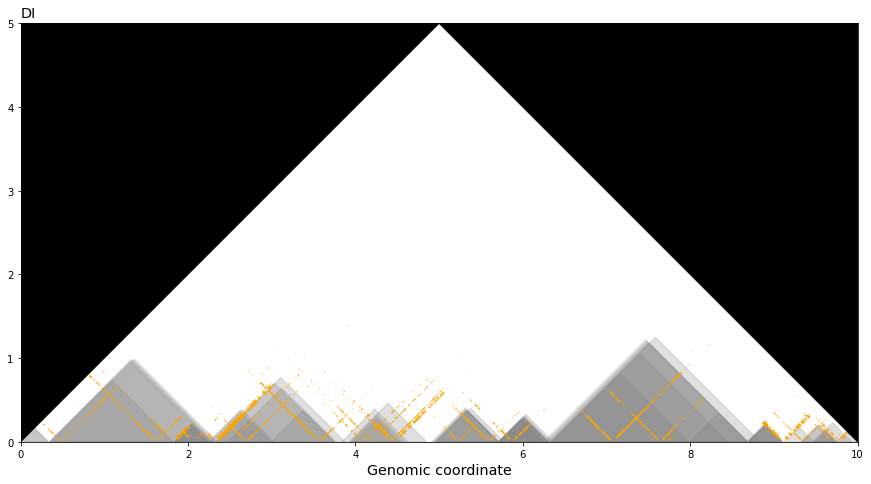

[INFO] Extracted 5146 interactions in range chr10:27500000-32500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  17.  20.  24.  29.  37.  55. 331.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 27500000 max: 32500000
[INFO] Got 1078 digests
[INFO] Got 1828 interactions
[INFO] begin:27500000
[INFO] end:32500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


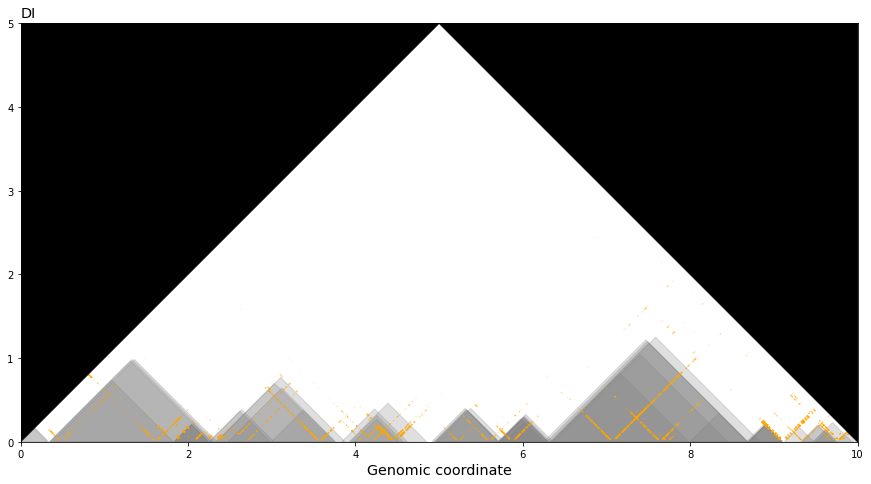

[INFO] Extracted 4859 interactions in range chr10:30000000-35000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  13.  15.  18.  21.  26.  31.  40.  57. 331.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 30000000 max: 35000000
[INFO] Got 1225 digests
[INFO] Got 2158 interactions
[INFO] begin:30000000
[INFO] end:35000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


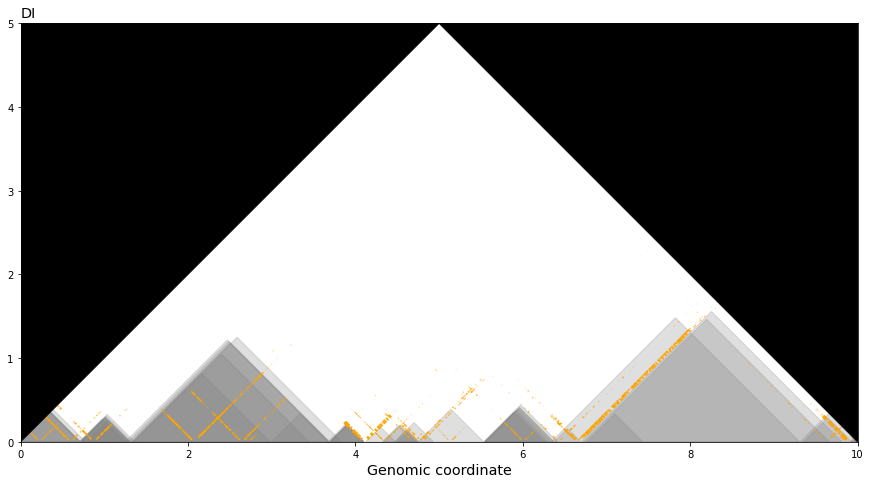

[INFO] Extracted 3841 interactions in range chr10:30000000-35000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  11.  13.  15.  18.  22.  27.  35.  49. 283.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 30000000 max: 35000000
[INFO] Got 898 digests
[INFO] Got 1525 interactions
[INFO] begin:30000000
[INFO] end:35000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


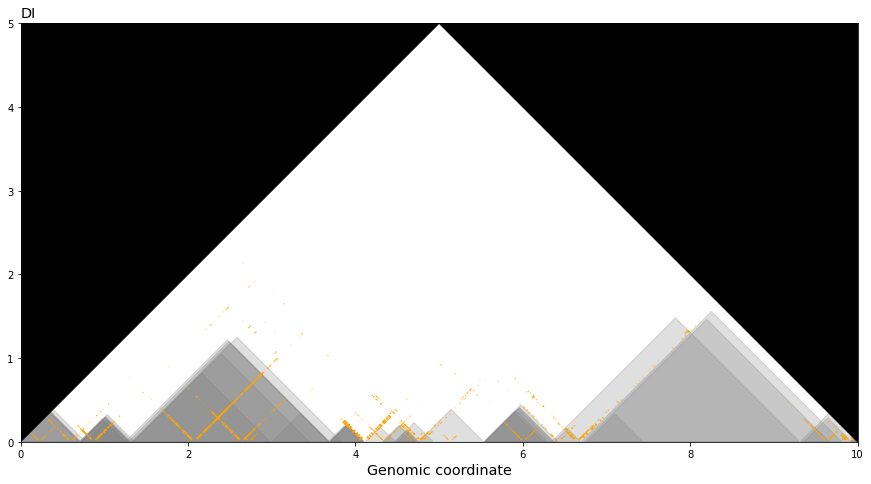

[INFO] Extracted 4636 interactions in range chr10:32500000-37500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  17.  20.  24.  29.  37.  52. 268.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 32500000 max: 37500000
[INFO] Got 965 digests
[INFO] Got 1805 interactions
[INFO] begin:32500000
[INFO] end:37500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


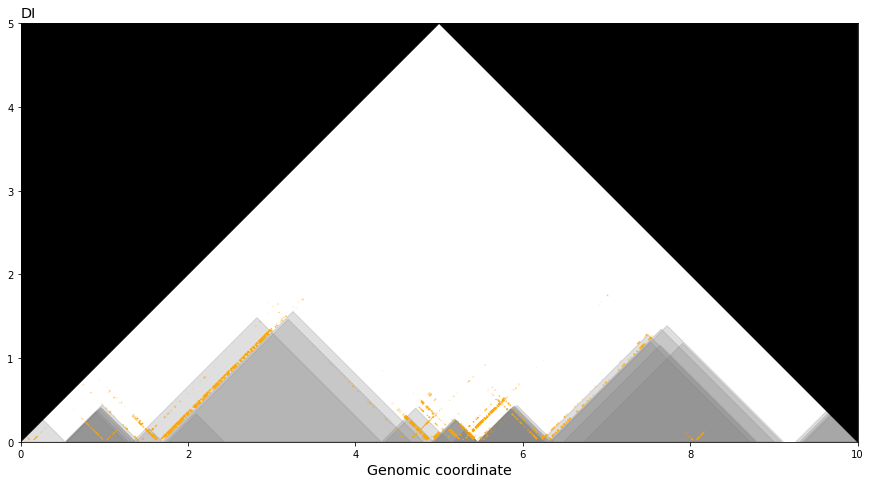

[INFO] Extracted 3149 interactions in range chr10:32500000-37500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  11.  13.  15.  17.  20.  24.  31.  45. 367.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 32500000 max: 37500000
[INFO] Got 661 digests
[INFO] Got 1142 interactions
[INFO] begin:32500000
[INFO] end:37500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


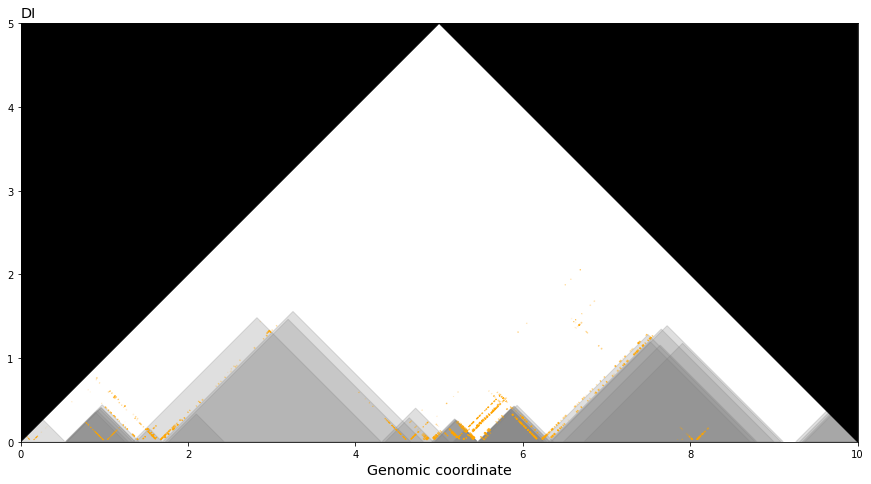

[INFO] Extracted 1713 interactions in range chr10:35000000-40000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  11.  13.  15.  17.  21.  25.  31.  44. 213.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 35000000 max: 40000000
[INFO] Got 487 digests
[INFO] Got 815 interactions
[INFO] begin:35000000
[INFO] end:40000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


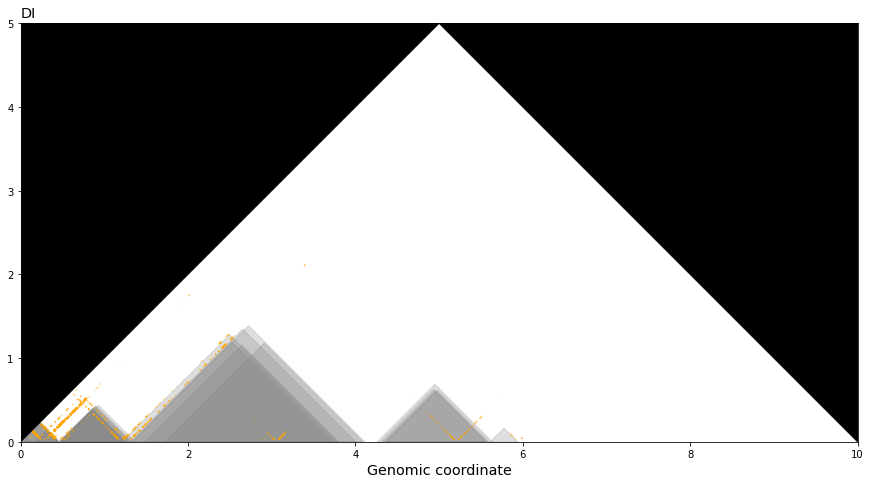

[INFO] Extracted 1793 interactions in range chr10:35000000-40000000
[INFO] Read pair count quantiles:
	[INFO] [  9.9  11.   12.7  14.   16.   19.   23.   29.   40.1 367. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 35000000 max: 40000000
[INFO] Got 459 digests
[INFO] Got 780 interactions
[INFO] begin:35000000
[INFO] end:40000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


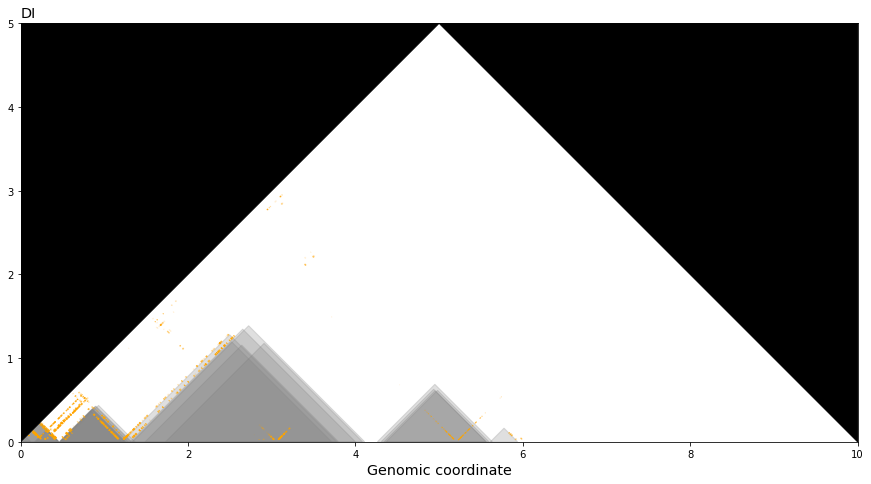

[INFO] Extracted 126 interactions in range chr10:37500000-42500000
[INFO] Read pair count quantiles:
	[INFO] [ 9.  11.  13.  14.  16.  18.  20.  24.  31.2 62. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 37500000 max: 42500000
[INFO] Got 95 digests
[INFO] Got 98 interactions
[INFO] begin:37500000
[INFO] end:42500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


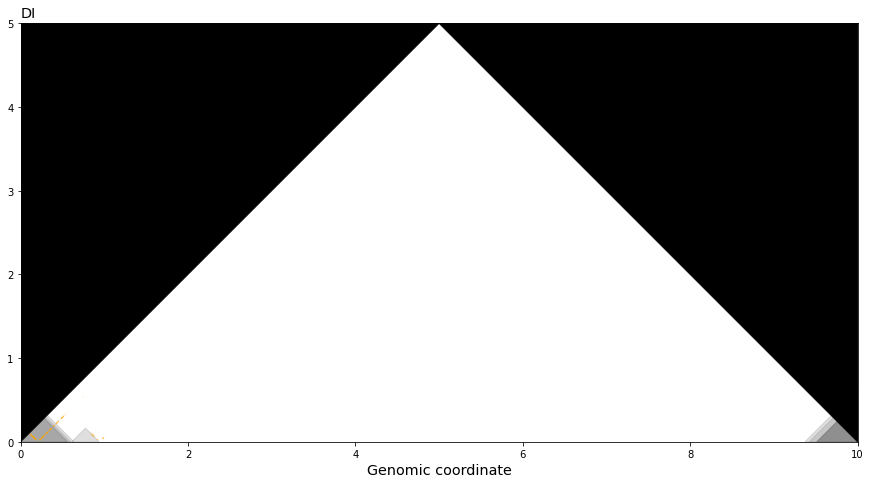

[INFO] Extracted 114 interactions in range chr10:37500000-42500000
[INFO] Read pair count quantiles:
	[INFO] [10.  11.  12.  14.  15.  17.  20.5 24.  34.  77. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 37500000 max: 42500000
[INFO] Got 78 digests
[INFO] Got 76 interactions
[INFO] begin:37500000
[INFO] end:42500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


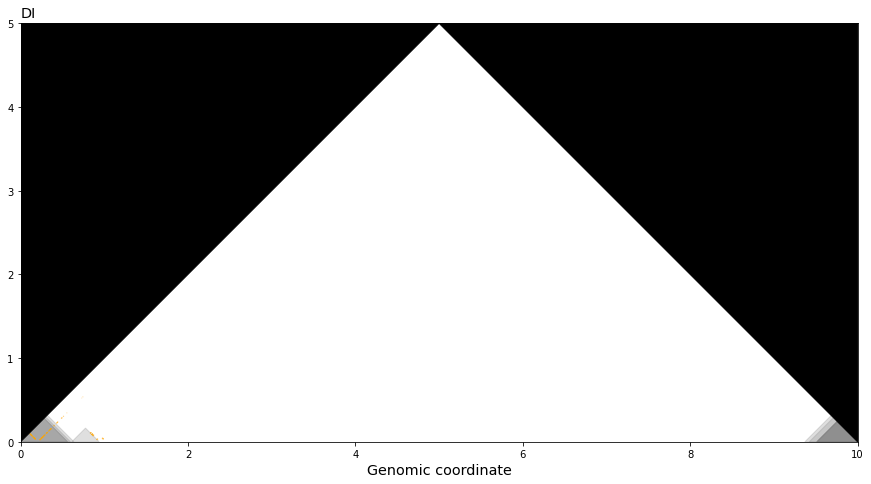

[INFO] Extracted 4340 interactions in range chr10:40000000-45000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  16.  19.  22.  28.  34.  48. 371.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 40000000 max: 45000000
[INFO] Got 598 digests
[INFO] Got 2225 interactions
[INFO] begin:40000000
[INFO] end:45000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


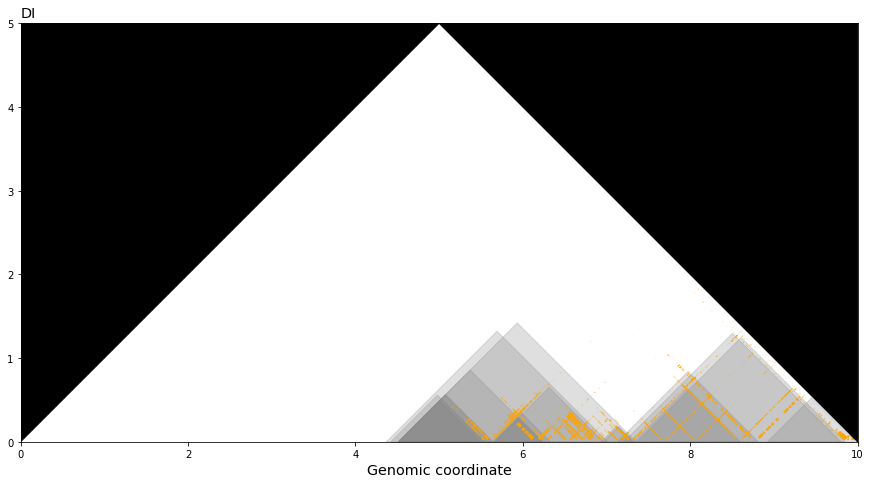

[INFO] Extracted 3108 interactions in range chr10:40000000-45000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  11.  13.  15.  16.  19.  22.  26.  36. 244.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 40000000 max: 45000000
[INFO] Got 561 digests
[INFO] Got 1652 interactions
[INFO] begin:40000000
[INFO] end:45000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


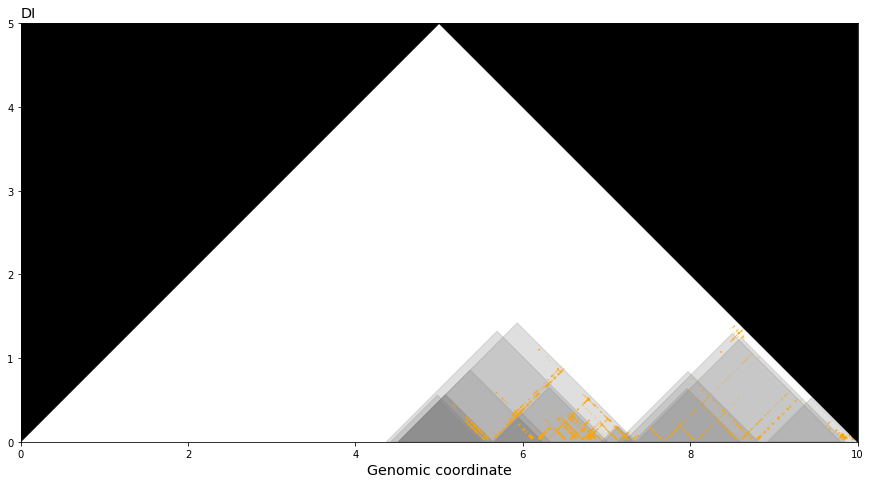

[INFO] Extracted 6608 interactions in range chr10:42500000-47500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  16.  19.  22.  27.  34.  48. 371.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 42500000 max: 47500000
[INFO] Got 868 digests
[INFO] Got 3021 interactions
[INFO] begin:42500000
[INFO] end:47500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


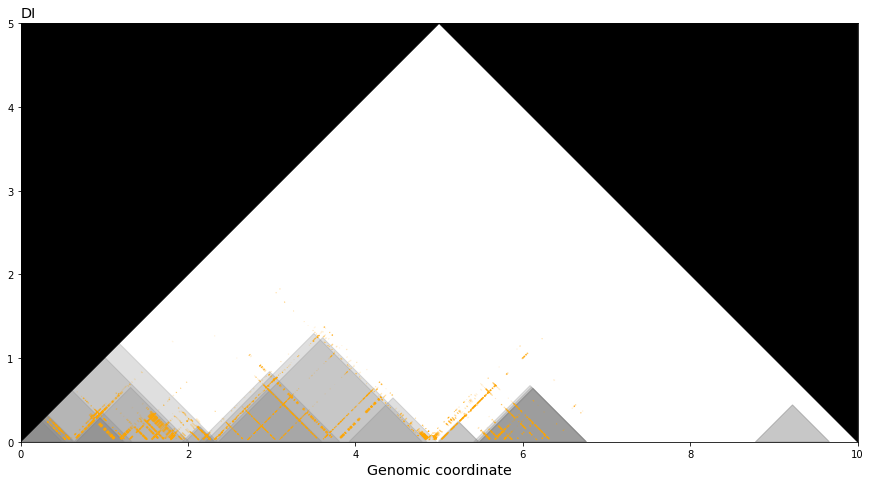

[INFO] Extracted 4946 interactions in range chr10:42500000-47500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.   12.   13.   15.   17.   20.   23.   28.   38.7 244. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 42500000 max: 47500000
[INFO] Got 817 digests
[INFO] Got 2274 interactions
[INFO] begin:42500000
[INFO] end:47500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


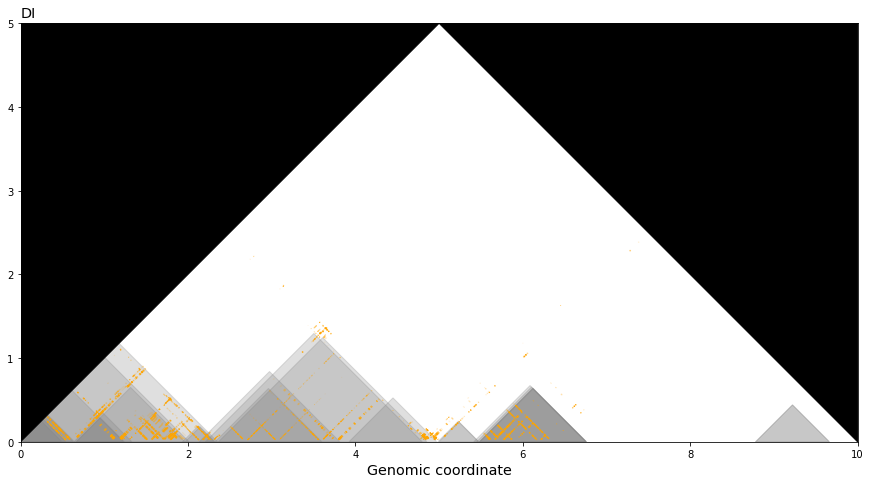

[INFO] Extracted 5997 interactions in range chr10:45000000-50000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  17.  20.  24.  29.  36.  52. 211.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 45000000 max: 50000000
[INFO] Got 656 digests
[INFO] Got 2670 interactions
[INFO] begin:45000000
[INFO] end:50000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


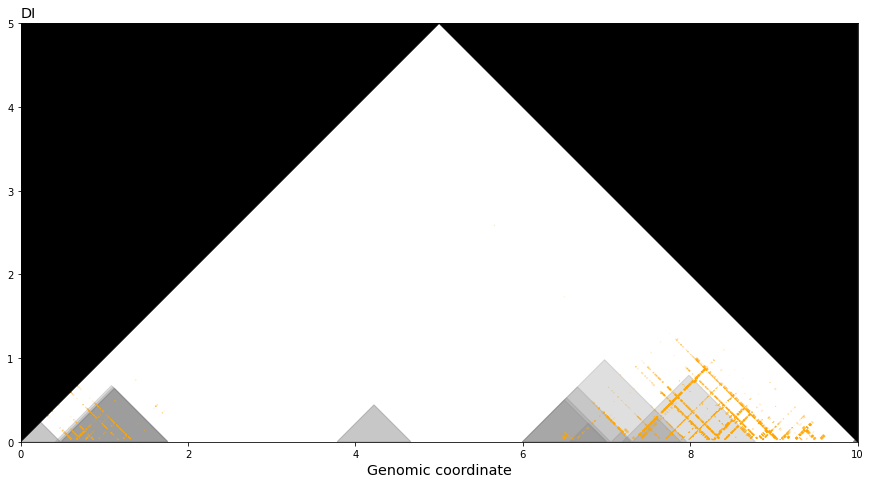

[INFO] Extracted 5261 interactions in range chr10:45000000-50000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  16.  18.  21.  25.  32.  47. 367.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 45000000 max: 50000000
[INFO] Got 617 digests
[INFO] Got 2101 interactions
[INFO] begin:45000000
[INFO] end:50000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


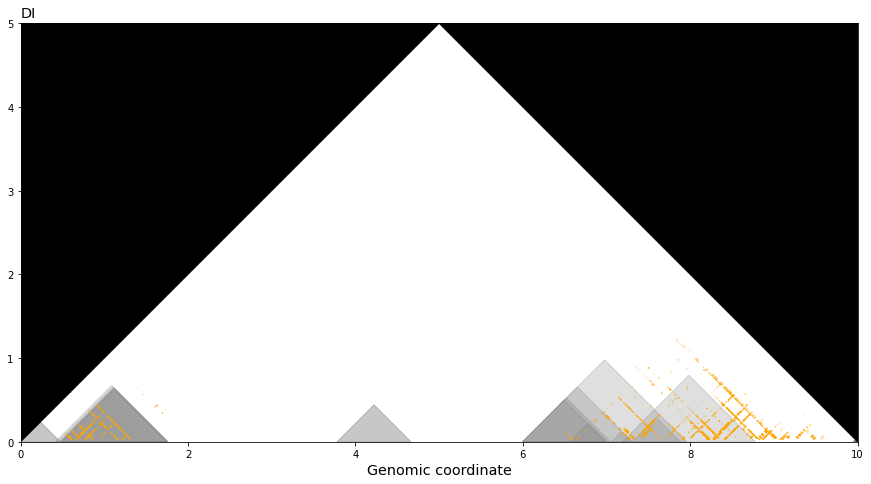

[INFO] Extracted 8092 interactions in range chr10:47500000-52500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  13.  15.  19.  22.  27.  33.  43.  63. 275.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 47500000 max: 52500000
[INFO] Got 891 digests
[INFO] Got 3069 interactions
[INFO] begin:47500000
[INFO] end:52500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


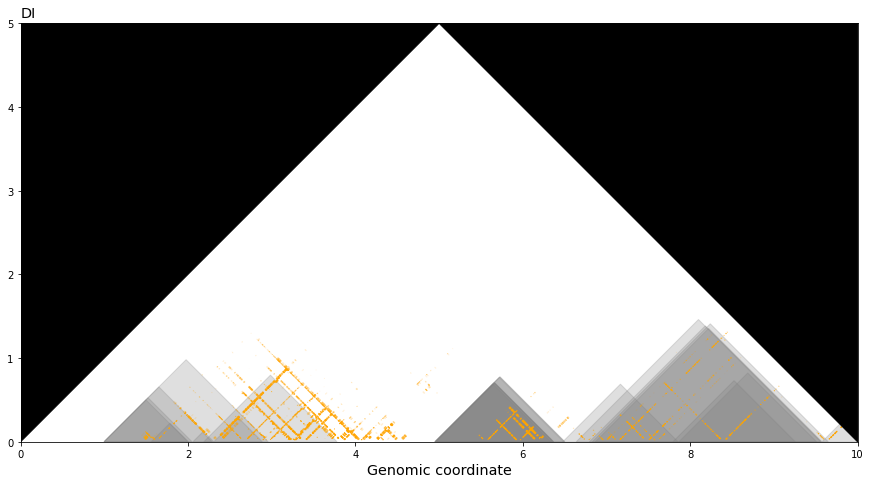

[INFO] Extracted 7124 interactions in range chr10:47500000-52500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  16.  19.  23.  28.  37.  53. 367.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 47500000 max: 52500000
[INFO] Got 811 digests
[INFO] Got 2325 interactions
[INFO] begin:47500000
[INFO] end:52500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


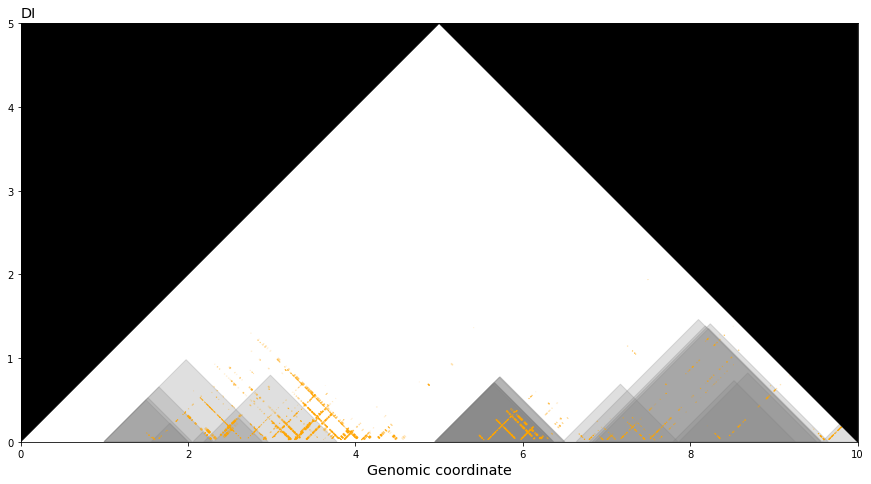

In [57]:
chrom = 'chr10'
for start_pos in range(5000000,50000000,2500000):
    begin = start_pos
    end = begin + 5000000
    inter_dict_1 = visualizer_1.extract_interactions(chrom=chrom, begin=begin, end=end)
    visualizer_1.create_visualization(chrom=chrom,
                                begin=begin,
                                end=end,
                                inter_cat='DI',
                                enr_cat_list=['NE','EN'],
                                inter_dict=inter_dict_1)
    inter_dict_2 = visualizer_2.extract_interactions(chrom=chrom, begin=begin, end=end)
    visualizer_2.create_visualization(chrom=chrom,
                                begin=begin,
                                end=end,
                                inter_cat='DI',
                                enr_cat_list=['NE','EN'],
                                inter_dict=inter_dict_2)

### Possible plots for publication

[INFO] Extracted 8444 interactions in range chr10:12500000-15500000
[INFO] Read pair count quantiles:
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
	[INFO] [ 10.  12.  14.  17.  20.  25.  31.  43.  68. 694.]
[INFO] Got 5456 interactions
[INFO] begin: 12500000
[INFO] end: 15500000
[TEST] pos_to_coordinate(begin): 0.0
[TEST] pos_to_coordinate(end): 10.0
[TEST] coordinate_to_pos(pos_to_coordinate(begin)): 12500000.0
[TEST] coordinate_to_pos(pos_to_coordinate(end)): 15500000.0


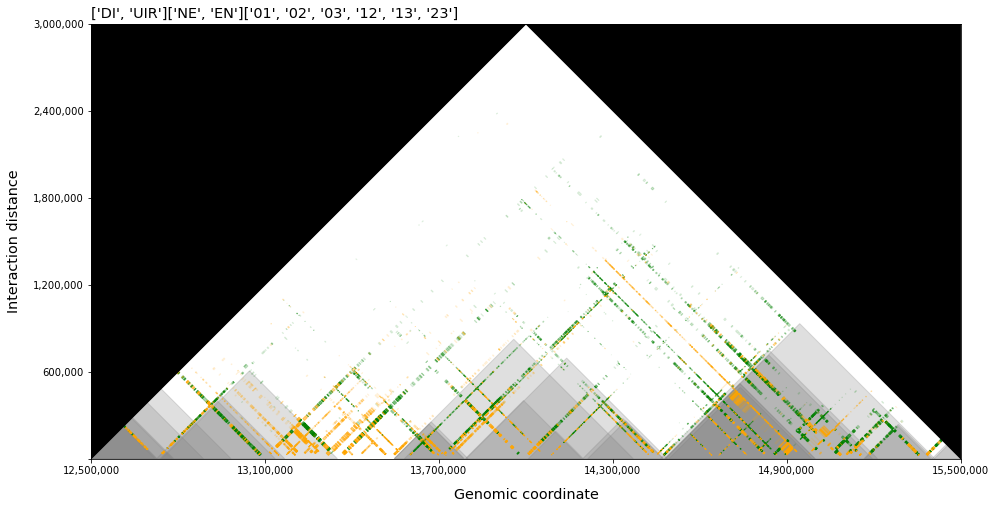

In [25]:
chrom = 'chr10'
begin = 12500000
end = begin + 3000000

visualizer.create_visualization(chrom = chrom,
                                begin = begin,
                                end = end,
                                inter_cat_list = ['DI','UIR'],
                                enr_cat_list = ['NE','EN'],
                                color_i_cats = True)